# Unify overlapping bounding boxes
This script treats the outputted bounding boxes from Strabo in order to unify overlapping bounding boxes which cover one and the same label of the historical map. Afterwards, text image areas can be cut out off the historical map which is represented by a raster image.<br>
<img src="fig04.png" width="300"><br>
common abbreviations within this script:<br>
- DF = DataFrame
- GDF = GeoDataFrame
- CRS = coordinate reference system
- BB = bounding box

## import libraries

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import *
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime
from contextlib import contextmanager
import sys, os

In [2]:
# function to prevent printing the output
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

# 1) import shapefile (= output from Strabo)
The output vector file from Strabo containing the bounding boxes (geoJson1.json) was converted to shapefile in QGIS.

In [3]:
# import the shapefile containing the bounding boxes of the labels (= ouput from Strabo)
data_path = 'data/input/boundingboxes.shp'
data_strabo = gpd.read_file(data_path)

# define the output path
output_path = 'data/output'

# 2) *data_strabo* bereinigen

In [4]:
# rename column *ImageId* into *id*
data_strabo.rename(columns={'ImageId':'id'}, inplace=True)

# drop unnecessary attributes which were crated by Strabo
del data_strabo['NameAfterD']
del data_strabo['NameBefore']
del data_strabo['Dictionary']
del data_strabo['TesseractC']
del data_strabo['SameMatche']

# drop negative values from column *inclinatio* (created by Strabo) and standardize those
data_strabo.loc[data_strabo['inclinatio'] <= 0, 'inclinatio'] = data_strabo.inclinatio+180
data_strabo.loc[data_strabo['inclinatio'] > 0, 'inclinatio'] = data_strabo.inclinatio

# 3) compute the area of the boundig boxes in *data_strabo*

In [5]:
# add a new column called *area_boundingbox* and fill it with the area
data_strabo["area_boundingbox"] = data_strabo['geometry'].area

# convert column *id* to String (which is a prerequisite for the subsequent intersection)
data_strabo['id'] = data_strabo['id'].astype(str)

# print all rows
pd.set_option('display.max_rows', len(data_strabo)+1)
data_strabo

,id,inclinatio,geometry,area_boundingbox
0,0,167.788492,"POLYGON ((159.000 -419.000, 293.000 -390.000, ...",2662.0
1,1,1.432096,"POLYGON ((502.000 -340.000, 662.000 -343.000, ...",2800.0
2,2,179.356254,"POLYGON ((773.000 -474.000, 862.000 -473.000, ...",1335.0
3,3,170.112011,"POLYGON ((609.000 -840.000, 717.000 -820.000, ...",1622.0
4,4,167.042420,"POLYGON ((830.000 -812.000, 943.000 -786.000, ...",1912.0
5,5,1.134422,"POLYGON ((250.000 -744.000, 351.000 -745.000, ...",1464.5
6,6,3.136358,"POLYGON ((336.000 -534.000, 409.000 -537.000, ...",1281.0
7,7,176.863642,"POLYGON ((1002.000 -209.000, 1075.000 -206.000...",1208.0
8,8,178.707833,"POLYGON ((802.000 -420.000, 935.000 -417.000, ...",2188.0
9,9,1.070824,"POLYGON ((571.000 -288.000, 677.000 -290.000, ...",1811.5


In [6]:
# define a metric coordinate system (UTM 32N)
data_strabo.crs = "EPSG:25832"

strabo_folder = output_path+'/temp_output'
if not os.path.exists(strabo_folder): # if it does not exist yet...
    os.makedirs(strabo_folder) # ...create new folder in directory to save the output in it

data_strabo.to_file(output_path+"/temp_output/data_strabo.shp")

In [7]:
# make a copy of *data_strabo* in order to work with the original data_strabo later on
data_original = data_strabo.copy()

## 3.1) plot *data_strabo*

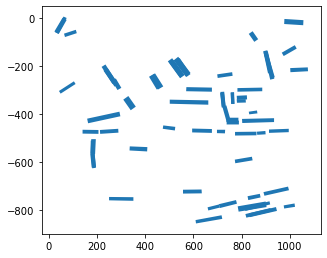

In [8]:
%matplotlib inline
data_strabo.plot(figsize = (5, 5))

# 4) generate intersection/overlapping areas between the bounding boxes in *data_strabo*

The template for this code block comes from https://medium.com/@achm.firmansyah/an-approach-for-checking-overlaps-and-gaps-in-polygons-using-geopandas-ebd6606e7f70

In [9]:
# generate overlapping areas

strabo_overlaps = gpd.GeoDataFrame(crs = data_strabo.crs)

for index, row in data_strabo.iterrows():
    data_strabo_temp = data_strabo.loc[data_strabo.id!=row.id,]
    
    # check if any intersection occurs
    overlaps = data_strabo_temp[data_strabo_temp.geometry.overlaps(row.geometry)]['id'].tolist()
    
    if len(overlaps) > 0:
        temp_list = []
        
        # compare the area with a threshold
        for y in overlaps:
            temp_area = gpd.overlay(data_strabo.loc[data_strabo.id==y,],data_strabo.loc[data_strabo.id==row.id,],how='intersection')
            temp_area = temp_area.loc[temp_area.geometry.area>=9e-9]
            
            if temp_area.shape[0] > 0:
                strabo_overlaps = gpd.GeoDataFrame(pd.concat([temp_area,strabo_overlaps],ignore_index=True),crs=data_strabo.crs)

# get unique of list *id*
strabo_overlaps["sorted"] = strabo_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
strabo_overlaps["sorted"] = strabo_overlaps.sorted.apply(lambda y:''.join(y))
strabo_overlaps = strabo_overlaps.drop_duplicates('sorted') # otherwise all entries would exist twice
strabo_overlaps = strabo_overlaps.reset_index()[['id_1','id_2','geometry']]

strabo_overlaps

,id_1,id_2,geometry
0,55,63,"POLYGON ((181.000 -564.000, 190.000 -563.000, ..."
1,43,63,"POLYGON ((173.049 -564.000, 175.705 -510.000, ..."
2,41,63,"POLYGON ((190.000 -563.000, 190.015 -563.182, ..."
3,49,62,"POLYGON ((275.490 -284.288, 262.000 -262.000, ..."
4,42,62,"POLYGON ((251.200 -219.560, 280.000 -265.000, ..."
5,4,61,"POLYGON ((830.000 -812.000, 920.325 -791.217, ..."
6,39,60,"POLYGON ((907.000 -142.000, 920.704 -188.416, ..."
7,21,60,"POLYGON ((907.925 -139.253, 927.000 -227.000, ..."
8,50,59,"POLYGON ((756.000 -334.000, 755.042 -311.000, ..."
9,51,58,"POLYGON ((561.706 -236.225, 545.000 -249.000, ..."


## 4.1) plot *data_strabo* and all overlaps

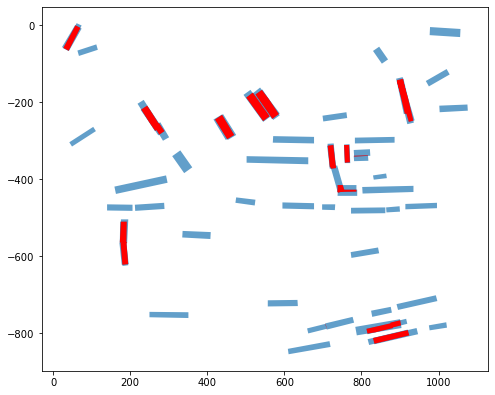

In [10]:
# plot bounding boxes (*data_strabo*, blue) and their intersections/overlaps (*strabo_overlaps*, red)
ax = data_strabo.plot(figsize=(8, 8),alpha=0.7)
strabo_overlaps.plot(ax=ax,color='red')

# 5) Dissolve/Unify overlapping Bounding Boxes IF they fulfill the following conditions 5.1) and 5.2)

## 5.1) Dissolve if (area_overlap / area_smaller_BB * 100) > 50 %

<img src="fig05.1.png" width="600">

### 5.1.1) add the area of the overlaps as a new column in *strabo_overlaps*

In [11]:
# Add a new column called *area_overlap* and fill it with the area
strabo_overlaps["area_overlap"] = strabo_overlaps['geometry'].area

# convert *id*, *id_1* and *id_2* back to Integer
strabo_overlaps.id_1 = strabo_overlaps['id_1'].astype(int)
strabo_overlaps.id_2 = strabo_overlaps['id_2'].astype(int)

strabo_overlaps

,id_1,id_2,geometry,area_overlap
0,55,63,"POLYGON ((181.000 -564.000, 190.000 -563.000, ...",4.507874
1,43,63,"POLYGON ((173.049 -564.000, 175.705 -510.000, ...",870.639344
2,41,63,"POLYGON ((190.000 -563.000, 190.015 -563.182, ...",7.507576
3,49,62,"POLYGON ((275.490 -284.288, 262.000 -262.000, ...",403.164823
4,42,62,"POLYGON ((251.200 -219.560, 280.000 -265.000, ...",1236.910117
5,4,61,"POLYGON ((830.000 -812.000, 920.325 -791.217, ...",1364.986562
6,39,60,"POLYGON ((907.000 -142.000, 920.704 -188.416, ...",1592.937340
7,21,60,"POLYGON ((907.925 -139.253, 927.000 -227.000, ...",1394.251400
8,50,59,"POLYGON ((756.000 -334.000, 755.042 -311.000, ...",592.020833
9,51,58,"POLYGON ((561.706 -236.225, 545.000 -249.000, ...",1567.754722


In [12]:
# convert *id* in *data_strabo* to Integer
data_strabo['id'] = data_strabo['id'].astype(int)

Rename the geometry columns in *data_strabo* and *strabo_overlaps* so that both geometries can be listed within one geodataframe without overwriting each other. This step is necessary for the subsequent merging of those 2 datasets.

In [13]:
with suppress_stdout():
    data_strabo.rename(columns={"geometry": "geometry_boundingbox"},inplace=True)
    strabo_overlaps.rename(columns={"geometry": "geometry_overlap"},inplace=True)

### 5.1.2) merge *data_strabo* and *strabo_overlaps* into one GeoDataFrame
so that both *areas* are included within one dataset

In [14]:
# 1)
strabo_and_overlaps_temp = pd.merge(data_strabo, strabo_overlaps, how='inner', left_on='id', right_on='id_1')
#strabo_and_overlaps_temp

In [15]:
# 2)
strabo_and_overlaps = pd.merge(strabo_and_overlaps_temp, data_strabo, how='inner', left_on='id_2', right_on='id')
strabo_and_overlaps

,id_x,inclinatio_x,geometry_boundingbox_x,area_boundingbox_x,id_1,id_2,geometry_overlap,area_overlap,id_y,inclinatio_y,geometry_boundingbox_y,area_boundingbox_y
0,4,167.042420,"POLYGON ((830.000 -812.000, 943.000 -786.000, ...",1912.0,4,61,"POLYGON ((830.000 -812.000, 920.325 -791.217, ...",1364.986562,61,166.483432,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",1660.0
1,18,177.273689,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",716.0,18,28,"POLYGON ((817.092 -339.281, 781.000 -341.000, ...",59.808838,28,178.451842,"POLYGON ((780.000 -339.000, 817.000 -338.000, ...",519.0
2,20,180.000000,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",808.0,20,48,"POLYGON ((739.000 -427.000, 755.136 -427.000, ...",93.843359,48,74.167613,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",1216.0
3,35,178.830861,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",857.5,35,48,"POLYGON ((738.000 -415.000, 751.682 -415.000, ...",275.318110,48,74.167613,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",1216.0
4,44,84.382419,"POLYGON ((728.000 -307.000, 734.000 -368.000, ...",982.0,44,48,"POLYGON ((733.683 -364.780, 734.000 -368.000, ...",28.555561,48,74.167613,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",1216.0
5,20,180.000000,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",808.0,20,35,"POLYGON ((739.000 -427.000, 787.000 -427.000, ...",264.628991,35,178.830861,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",857.5
6,21,77.735226,"POLYGON ((890.000 -139.000, 907.000 -135.000, ...",1644.0,21,60,"POLYGON ((907.925 -139.253, 927.000 -227.000, ...",1394.251400,60,76.675469,"POLYGON ((919.000 -257.000, 892.000 -143.000, ...",2046.0
7,39,73.551392,"POLYGON ((907.000 -142.000, 938.000 -247.000, ...",1699.0,39,60,"POLYGON ((907.000 -142.000, 920.704 -188.416, ...",1592.937340,60,76.675469,"POLYGON ((919.000 -257.000, 892.000 -143.000, ...",2046.0
8,21,77.735226,"POLYGON ((890.000 -139.000, 907.000 -135.000, ...",1644.0,21,39,"POLYGON ((912.771 -161.548, 927.000 -227.000, ...",1189.790841,39,73.551392,"POLYGON ((907.000 -142.000, 938.000 -247.000, ...",1699.0
9,27,165.963757,"POLYGON ((659.000 -787.000, 707.000 -775.000, ...",660.0,27,30,"POLYGON ((706.294 -775.176, 707.000 -775.000, ...",8.088235,30,165.774036,"POLYGON ((706.000 -774.000, 777.000 -757.000, ...",1170.5


Now, we select only needed columns to have a better overview. We make a copy of *strabo_and_overlaps* (*strabo_overlaps_filtered_temp*) and hand over only the necessary columns.

In [16]:
strabo_overlaps_filtered_temp = strabo_and_overlaps[['id_1','id_2',
                                                     'geometry_boundingbox_x','area_boundingbox_x',
                                                     'geometry_boundingbox_y','area_boundingbox_y',
                                                     'area_overlap','geometry_overlap']]

# rename the columns for a better understanding
strabo_overlaps_filtered_temp.rename(columns={"geometry_boundingbox_x": "geometry_boundingbox_1", 
                                              "area_boundingbox_x": "area_boundingbox_1",
                                              "geometry_boundingbox_y": "geometry_boundingbox_2", 
                                              "area_boundingbox_y": "area_boundingbox_2"},
                                     inplace=True)

strabo_overlaps_filtered_temp

C:\Users\schlegel\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id_1,id_2,geometry_boundingbox_1,area_boundingbox_1,geometry_boundingbox_2,area_boundingbox_2,area_overlap,geometry_overlap
0,4,61,"POLYGON ((830.000 -812.000, 943.000 -786.000, ...",1912.0,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",1660.0,1364.986562,"POLYGON ((830.000 -812.000, 920.325 -791.217, ..."
1,18,28,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",716.0,"POLYGON ((780.000 -339.000, 817.000 -338.000, ...",519.0,59.808838,"POLYGON ((817.092 -339.281, 781.000 -341.000, ..."
2,20,48,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",808.0,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",1216.0,93.843359,"POLYGON ((739.000 -427.000, 755.136 -427.000, ..."
3,35,48,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",857.5,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",1216.0,275.318110,"POLYGON ((738.000 -415.000, 751.682 -415.000, ..."
4,44,48,"POLYGON ((728.000 -307.000, 734.000 -368.000, ...",982.0,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",1216.0,28.555561,"POLYGON ((733.683 -364.780, 734.000 -368.000, ..."
5,20,35,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",808.0,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",857.5,264.628991,"POLYGON ((739.000 -427.000, 787.000 -427.000, ..."
6,21,60,"POLYGON ((890.000 -139.000, 907.000 -135.000, ...",1644.0,"POLYGON ((919.000 -257.000, 892.000 -143.000, ...",2046.0,1394.251400,"POLYGON ((907.925 -139.253, 927.000 -227.000, ..."
7,39,60,"POLYGON ((907.000 -142.000, 938.000 -247.000, ...",1699.0,"POLYGON ((919.000 -257.000, 892.000 -143.000, ...",2046.0,1592.937340,"POLYGON ((907.000 -142.000, 920.704 -188.416, ..."
8,21,39,"POLYGON ((890.000 -139.000, 907.000 -135.000, ...",1644.0,"POLYGON ((907.000 -142.000, 938.000 -247.000, ...",1699.0,1189.790841,"POLYGON ((912.771 -161.548, 927.000 -227.000, ..."
9,27,30,"POLYGON ((659.000 -787.000, 707.000 -775.000, ...",660.0,"POLYGON ((706.000 -774.000, 777.000 -757.000, ...",1170.5,8.088235,"POLYGON ((706.294 -775.176, 707.000 -775.000, ..."


### 5.1.3) calculate the overlapping percentage between each *overlap* polygon and its smaller overlapping polygon

In [17]:
# Add a new column called *percent_overlap* which - in the next step - shall be filled with
# overlapping percentage between overlap polygon and its smaller overlapping polygon 
strabo_overlaps_filtered_temp.insert(5, "percent_overlap", None)

In [18]:
# calculate the percentual overlap of the overlap area with the smaller polygon (id_1 oder id_2)
def calculatepercentage(input_gdf, var1, var2, var3, var4):
    input_gdf[var3] = np.where(
        input_gdf[var1] < input_gdf[var2],
        round(input_gdf[var4]/input_gdf[var1]*100,2),
        round(input_gdf[var4]/input_gdf[var2]*100,2))
    return input_gdf

In [19]:
strabo_overlaps_filtered = calculatepercentage(strabo_overlaps_filtered_temp,
                                               'area_boundingbox_1', 'area_boundingbox_2',
                                               'percent_overlap', 'area_overlap')

# sort by *percent_overlap* (descending)
strabo_overlaps_filtered.sort_values(by='percent_overlap',ascending=False)

C:\Users\schlegel\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_1,id_2,geometry_boundingbox_1,area_boundingbox_1,geometry_boundingbox_2,percent_overlap,area_boundingbox_2,area_overlap,geometry_overlap
30,50,59,"POLYGON ((769.000 -309.000, 771.000 -358.000, ...",680.0,"POLYGON ((757.000 -357.000, 755.000 -311.000, ...",99.92,592.5,592.020833,"POLYGON ((756.000 -334.000, 755.042 -311.000, ..."
11,32,40,"POLYGON ((813.000 -788.000, 879.000 -773.000, ...",937.5,"POLYGON ((900.000 -763.000, 904.000 -786.000, ...",98.27,2688.0,921.240480,"POLYGON ((813.000 -788.000, 879.000 -773.000, ..."
26,51,58,"POLYGON ((518.000 -175.000, 562.000 -236.000, ...",1609.0,"POLYGON ((545.000 -251.000, 494.000 -181.000, ...",97.44,1923.0,1567.754722,"POLYGON ((561.706 -236.225, 545.000 -249.000, ..."
15,43,63,"POLYGON ((195.000 -504.000, 192.000 -566.000, ...",1170.0,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",94.84,918.0,870.639344,"POLYGON ((173.049 -564.000, 175.705 -510.000, ..."
17,41,55,"POLYGON ((190.000 -563.000, 195.000 -623.000, ...",915.0,"POLYGON ((178.000 -622.000, 172.000 -565.000, ...",94.44,1038.0,864.107583,"POLYGON ((190.000 -563.000, 194.761 -620.138, ..."
27,46,56,"POLYGON ((537.000 -162.000, 588.000 -229.000, ...",2064.0,"POLYGON ((571.000 -246.000, 525.000 -180.000, ...",94.06,1732.5,1629.569221,"POLYGON ((541.584 -168.022, 559.455 -191.500, ..."
7,39,60,"POLYGON ((907.000 -142.000, 938.000 -247.000, ...",1699.0,"POLYGON ((919.000 -257.000, 892.000 -143.000, ...",93.76,2046.0,1592.937340,"POLYGON ((907.000 -142.000, 920.704 -188.416, ..."
10,29,54,"POLYGON ((61.000 5.000, 74.000 -1.000, 40.000 ...",1108.5,"POLYGON ((23.000 -57.000, 57.000 0.000, 74.000...",90.18,1324.5,999.658249,"POLYGON ((70.762 -7.286, 40.223 -66.568, 26.55..."
23,44,57,"POLYGON ((728.000 -307.000, 734.000 -368.000, ...",982.0,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",88.56,974.0,862.613305,"POLYGON ((733.653 -368.022, 718.000 -369.000, ..."
6,21,60,"POLYGON ((890.000 -139.000, 907.000 -135.000, ...",1644.0,"POLYGON ((919.000 -257.000, 892.000 -143.000, ...",84.81,2046.0,1394.251400,"POLYGON ((907.925 -139.253, 927.000 -227.000, ..."


### 5.1.4) add a new column *id_combi* to have the ids of two overlapping polygons in one row
*id_combi* combines *id_1* und *id_2* within one column and is built up as follows: *id_1*_*id_2* (e.g. 51_55).

In [20]:
# Add a new column called *id_combi* and fill it with id_1 and id_2
strabo_overlaps_filtered["id_combi"] = strabo_overlaps_filtered['id_1'].astype(str) + '_' + strabo_overlaps_filtered['id_2'].astype(str)

C:\Users\schlegel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
# move *id_combi* to the front and also rearrange the other columns
strabo_overlaps_filtered[['id_1', 'id_2', 'id_combi',
                          'geometry_boundingbox_1', 'geometry_boundingbox_2', 'geometry_overlap',
                          'area_boundingbox_1', 'area_boundingbox_2', 'area_overlap', 'percent_overlap']]

,id_1,id_2,id_combi,geometry_boundingbox_1,geometry_boundingbox_2,geometry_overlap,area_boundingbox_1,area_boundingbox_2,area_overlap,percent_overlap
0,4,61,4_61,"POLYGON ((830.000 -812.000, 943.000 -786.000, ...","POLYGON ((820.000 -830.000, 816.000 -815.000, ...","POLYGON ((830.000 -812.000, 920.325 -791.217, ...",1912.0,1660.0,1364.986562,82.23
1,18,28,18_28,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...","POLYGON ((780.000 -339.000, 817.000 -338.000, ...","POLYGON ((817.092 -339.281, 781.000 -341.000, ...",716.0,519.0,59.808838,11.52
2,20,48,20_48,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...","POLYGON ((737.000 -364.000, 756.000 -430.000, ...","POLYGON ((739.000 -427.000, 755.136 -427.000, ...",808.0,1216.0,93.843359,11.61
3,35,48,35_48,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...","POLYGON ((737.000 -364.000, 756.000 -430.000, ...","POLYGON ((738.000 -415.000, 751.682 -415.000, ...",857.5,1216.0,275.318110,32.11
4,44,48,44_48,"POLYGON ((728.000 -307.000, 734.000 -368.000, ...","POLYGON ((737.000 -364.000, 756.000 -430.000, ...","POLYGON ((733.683 -364.780, 734.000 -368.000, ...",982.0,1216.0,28.555561,2.91
5,20,35,20_35,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...","POLYGON ((738.000 -415.000, 787.000 -415.000, ...","POLYGON ((739.000 -427.000, 787.000 -427.000, ...",808.0,857.5,264.628991,32.75
6,21,60,21_60,"POLYGON ((890.000 -139.000, 907.000 -135.000, ...","POLYGON ((919.000 -257.000, 892.000 -143.000, ...","POLYGON ((907.925 -139.253, 927.000 -227.000, ...",1644.0,2046.0,1394.251400,84.81
7,39,60,39_60,"POLYGON ((907.000 -142.000, 938.000 -247.000, ...","POLYGON ((919.000 -257.000, 892.000 -143.000, ...","POLYGON ((907.000 -142.000, 920.704 -188.416, ...",1699.0,2046.0,1592.937340,93.76
8,21,39,21_39,"POLYGON ((890.000 -139.000, 907.000 -135.000, ...","POLYGON ((907.000 -142.000, 938.000 -247.000, ...","POLYGON ((912.771 -161.548, 927.000 -227.000, ...",1644.0,1699.0,1189.790841,72.37
9,27,30,27_30,"POLYGON ((659.000 -787.000, 707.000 -775.000, ...","POLYGON ((706.000 -774.000, 777.000 -757.000, ...","POLYGON ((706.294 -775.176, 707.000 -775.000, ...",660.0,1170.5,8.088235,1.23


### 5.1.5) bring all 3 geometries (*boundingboxes_id1*, *boundingboxes_id2* und *overlaps*) to an own geodataframe (including *id_combi*)

In [22]:
# bring Boundingboxes1 (*boundingboxes_id1*) to an own GeoDataFrame
boundingboxes_id1_df = strabo_overlaps_filtered[['id_combi','id_1','id_2','geometry_boundingbox_1','area_boundingbox_1','percent_overlap']] # output: DataFrame
boundingboxes_id1_df.rename(columns={'geometry_boundingbox_1':'_geom'}, inplace=True) # rename geometry column into *_geom*
boundingboxes_id1_df.rename(columns={'area_boundingbox_1':'area_boundingbox'}, inplace=True) # rename column *area_boundingbox_1*
boundingboxes_id1 = gpd.GeoDataFrame(boundingboxes_id1_df, geometry='_geom') # convert DataFrame to GeoDataFrame
boundingboxes_id1.set_geometry('_geom') # define geometry column
#boundingboxes_id1
#boundingboxes_id1.plot(figsize=(5,5),color='cyan',alpha=0.6,edgecolor='c')

C:\Users\schlegel\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id_combi,id_1,id_2,_geom,area_boundingbox,percent_overlap
0,4_61,4,61,"POLYGON ((830.000 -812.000, 943.000 -786.000, ...",1912.0,82.23
1,18_28,18,28,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",716.0,11.52
2,20_48,20,48,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",808.0,11.61
3,35_48,35,48,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",857.5,32.11
4,44_48,44,48,"POLYGON ((728.000 -307.000, 734.000 -368.000, ...",982.0,2.91
5,20_35,20,35,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",808.0,32.75
6,21_60,21,60,"POLYGON ((890.000 -139.000, 907.000 -135.000, ...",1644.0,84.81
7,39_60,39,60,"POLYGON ((907.000 -142.000, 938.000 -247.000, ...",1699.0,93.76
8,21_39,21,39,"POLYGON ((890.000 -139.000, 907.000 -135.000, ...",1644.0,72.37
9,27_30,27,30,"POLYGON ((659.000 -787.000, 707.000 -775.000, ...",660.0,1.23


In [23]:
# bring Boundingboxes2 (*boundingboxes_id2*) to an own GeoDataFrame
boundingboxes_id2_df = strabo_overlaps_filtered[['id_combi','id_1','id_2','geometry_boundingbox_2','area_boundingbox_2','percent_overlap']] # output: DataFrame
boundingboxes_id2_df.rename(columns={'geometry_boundingbox_2':'_geom'}, inplace=True) # rename geometry column into *_geom*
boundingboxes_id2_df.rename(columns={'area_boundingbox_2':'area_boundingbox'}, inplace=True) # rename column *area_boundingbox_2*
boundingboxes_id2 = gpd.GeoDataFrame(boundingboxes_id2_df, geometry='_geom') # convert DataFrame to GeoDataFrame
boundingboxes_id2.set_geometry('_geom') # define geometry column
#boundingboxes_id2
#boundingboxes_id2.plot(figsize=(5,5),color='cyan',alpha=0.6,edgecolor='c')

C:\Users\schlegel\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id_combi,id_1,id_2,_geom,area_boundingbox,percent_overlap
0,4_61,4,61,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",1660.0,82.23
1,18_28,18,28,"POLYGON ((780.000 -339.000, 817.000 -338.000, ...",519.0,11.52
2,20_48,20,48,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",1216.0,11.61
3,35_48,35,48,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",1216.0,32.11
4,44_48,44,48,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",1216.0,2.91
5,20_35,20,35,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",857.5,32.75
6,21_60,21,60,"POLYGON ((919.000 -257.000, 892.000 -143.000, ...",2046.0,84.81
7,39_60,39,60,"POLYGON ((919.000 -257.000, 892.000 -143.000, ...",2046.0,93.76
8,21_39,21,39,"POLYGON ((907.000 -142.000, 938.000 -247.000, ...",1699.0,72.37
9,27_30,27,30,"POLYGON ((706.000 -774.000, 777.000 -757.000, ...",1170.5,1.23


In [24]:
# bring overlaps (*only_overlaps*) to an own GeoDataFrame
only_overlaps_df = strabo_overlaps_filtered[['id_combi','id_1','id_2','geometry_overlap','area_overlap','percent_overlap']] # output: DataFrame
only_overlaps_df.rename(columns={'geometry_overlap':'_geom'}, inplace=True) # rename geometry column into *_geom*
only_overlaps = gpd.GeoDataFrame(only_overlaps_df, geometry='_geom') # convert DataFrame to GeoDataFrame
only_overlaps.set_geometry('_geom') # define geometrie column
#only_overlaps
#only_overlaps.plot(figsize=(5,5),color='cyan',alpha=0.6,edgecolor='c')

C:\Users\schlegel\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id_combi,id_1,id_2,_geom,area_overlap,percent_overlap
0,4_61,4,61,"POLYGON ((830.000 -812.000, 920.325 -791.217, ...",1364.986562,82.23
1,18_28,18,28,"POLYGON ((817.092 -339.281, 781.000 -341.000, ...",59.808838,11.52
2,20_48,20,48,"POLYGON ((739.000 -427.000, 755.136 -427.000, ...",93.843359,11.61
3,35_48,35,48,"POLYGON ((738.000 -415.000, 751.682 -415.000, ...",275.318110,32.11
4,44_48,44,48,"POLYGON ((733.683 -364.780, 734.000 -368.000, ...",28.555561,2.91
5,20_35,20,35,"POLYGON ((739.000 -427.000, 787.000 -427.000, ...",264.628991,32.75
6,21_60,21,60,"POLYGON ((907.925 -139.253, 927.000 -227.000, ...",1394.251400,84.81
7,39_60,39,60,"POLYGON ((907.000 -142.000, 920.704 -188.416, ...",1592.937340,93.76
8,21_39,21,39,"POLYGON ((912.771 -161.548, 927.000 -227.000, ...",1189.790841,72.37
9,27_30,27,30,"POLYGON ((706.294 -775.176, 707.000 -775.000, ...",8.088235,1.23


In [25]:
# # plot all 3 GeoDataFrames
# fig,ax1 = plt.subplots(figsize=(12,12))
# boundingboxes_id1.plot(ax=ax1, color='blue', alpha=0.6, edgecolor='b')
# boundingboxes_id2.plot(ax=ax1, color='cyan', alpha=0.6, edgecolor='c')
# only_overlaps.plot(ax=ax1, color='red', alpha=0.9, edgecolor='r')

In [26]:
# only_overlaps.crs="EPSG:25832" # define coordinate system to have a look at the data in GIS
# only_overlaps.to_file(output_path+"/temp_output/only_overlaps.shp") # export it to shapefile

### 5.1.6) if *percent_overlap* >= 50: dissolve *boundingbox_id1[ ]* & *boundingbox_id2[ ]* inside one row
The threshold of 50% was defined manually and bases on empirical values from testing with different input data

In [27]:
# bring boundingboxes_id1 and boundingboxes_id2 to one GDF: list one below the other
boundingboxes_id1_id2 = pd.concat([boundingboxes_id1, boundingboxes_id2])
pd.set_option('display.max_rows', boundingboxes_id1_id2.shape[0]+1)
boundingboxes_id1_id2

,id_combi,id_1,id_2,_geom,area_boundingbox,percent_overlap
0,4_61,4,61,"POLYGON ((830.000 -812.000, 943.000 -786.000, ...",1912.0,82.23
1,18_28,18,28,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",716.0,11.52
2,20_48,20,48,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",808.0,11.61
3,35_48,35,48,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",857.5,32.11
4,44_48,44,48,"POLYGON ((728.000 -307.000, 734.000 -368.000, ...",982.0,2.91
5,20_35,20,35,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",808.0,32.75
6,21_60,21,60,"POLYGON ((890.000 -139.000, 907.000 -135.000, ...",1644.0,84.81
7,39_60,39,60,"POLYGON ((907.000 -142.000, 938.000 -247.000, ...",1699.0,93.76
8,21_39,21,39,"POLYGON ((890.000 -139.000, 907.000 -135.000, ...",1644.0,72.37
9,27_30,27,30,"POLYGON ((659.000 -787.000, 707.000 -775.000, ...",660.0,1.23


In [28]:
# 1) if percent overlap >= 50...
percent_overlap_larger50_temp1 = boundingboxes_id1_id2.loc[boundingboxes_id1_id2['percent_overlap'] >= 50] # store only those rows with a percent_overlap value >= 50
#percent_overlap_larger50_temp1.sort_values('percent_overlap')

In [29]:
# 2) ... then dissolve ...
percent_overlap_larger50 = percent_overlap_larger50_temp1.dissolve(by='id_combi')
percent_overlap_larger50["area_boundingbox"] = percent_overlap_larger50['_geom'].area # recalculate new area_boundingbox of the now dissolved polygons
#percent_overlap_larger50

In [30]:
# *id_combi* should not be the index but a usual column
percent_overlap_larger50.reset_index(inplace=True) # convert the index *id_combi* into a usual colummn
percent_overlap_larger50.index = [x for x in range(0, len(percent_overlap_larger50.values))] # add new index
percent_overlap_larger50.index.name = 'id' # rename new index ('id')
percent_overlap_larger50

,id_combi,_geom,id_1,id_2,area_boundingbox,percent_overlap
id,,,,,,
0,21_39,"POLYGON ((912.771 -161.548, 938.000 -247.000, ...",21,39,2153.209159,72.37
1,21_60,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",21,60,2295.748600,84.81
2,29_54,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",29,54,1433.341751,90.18
3,32_40,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",32,40,2704.259520,98.27
4,36_40,"POLYGON ((900.000 -763.000, 900.484 -765.784, ...",36,40,2906.728006,61.05
5,39_60,"POLYGON ((919.000 -257.000, 895.592 -158.167, ...",39,60,2152.062660,93.76
6,41_55,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",41,55,1088.892417,94.44
7,42_62,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",42,62,1938.589883,77.99
8,43_63,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",43,63,1217.360656,94.84


In [31]:
# percent_overlap_larger50.crs="EPSG:25832" # define metric CRS
# percent_overlap_larger50.to_file(output_path+"/temp_output/percent_overlap_larger50.shp") # export to shapefile

As we always dissolved only two polygons so far, we have to dissolve again those cases where more than 2 polygons overlap each other.<br><br>
Therefore:

### 5.1.7) check again for overlaps within *percent_overlap_larger50* and dissolve those bounding boxes which overlap >= 50 % again

#### if any id_1 == id_1 | id_2 == id_2 | id_1 == id_2: <br><br> dissolve tuples in *percent_overlap_larger50*

In [32]:
duplicate_id1 = percent_overlap_larger50[percent_overlap_larger50.duplicated(['id_1'],keep=False)]
duplicate_id2 = percent_overlap_larger50[percent_overlap_larger50.duplicated(['id_2'],keep=False)]

In [33]:
percent_overlap_larger50['duplicate_id1_id2'] = percent_overlap_larger50['id_1'].isin(percent_overlap_larger50['id_2']) | percent_overlap_larger50['id_2'].isin(percent_overlap_larger50['id_1'])

**<span style="color:red">Caution: The *isin* function used here only works as *percent_overlap_larger50* has only one(!) case where *id_1* and *id_2* are identical. This preceding code block should therefore be adjusted for input data having more than one of those cases!</span><br>**

In [34]:
duplicate_id1_id2 = percent_overlap_larger50[percent_overlap_larger50['duplicate_id1_id2'] == True]

In [35]:
# dissolve *duplicate_id1_id2* by duplicate_id1_id2
boundingboxes_id1_id2 = duplicate_id1_id2.dissolve(by='duplicate_id1_id2')

# dissolve duplicate_id1 by id1
boundingboxes_id1 = duplicate_id1.dissolve(by='id_1')

# dissolve duplicate_id2 by id2
boundingboxes_id2 = duplicate_id2.dissolve(by='id_2')

### 5.1.8) Drop those original rows from *percent_overlap_larger50* which overlap each other

In [36]:
# remove original rows (duplicate_id1, duplicate_id2 and duplicate_id1_id2 - which now have been dissolved) 
# in percent_overlap_larger50

percent_overlap_larger50_without_dissolved_id1 = pd.concat([percent_overlap_larger50,duplicate_id1])
percent_overlap_larger50_without_dissolved_id1 = percent_overlap_larger50_without_dissolved_id1.drop_duplicates(subset='id_1', keep=False)

percent_overlap_larger50_without_dissolved_id2 = pd.concat([percent_overlap_larger50_without_dissolved_id1,duplicate_id2])
percent_overlap_larger50_without_dissolved_id2 = percent_overlap_larger50_without_dissolved_id2.drop_duplicates(subset='id_2', keep=False)

percent_overlap_larger50_without_dissolved_id1id2 = pd.concat([percent_overlap_larger50_without_dissolved_id2,duplicate_id1_id2])
percent_overlap_larger50_without_dissolved_id1id2 = percent_overlap_larger50_without_dissolved_id1id2.drop(percent_overlap_larger50_without_dissolved_id1id2[percent_overlap_larger50_without_dissolved_id1id2.duplicate_id1_id2 == True].index) # drop tuples where 'duplicate_id1_id2'==True
percent_overlap_larger50_without_dissolved_id1id2

,id_combi,_geom,id_1,id_2,area_boundingbox,percent_overlap,duplicate_id1_id2
id,,,,,,,
2,29_54,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",29,54,1433.341751,90.18,False
6,41_55,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",41,55,1088.892417,94.44,False
7,42_62,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",42,62,1938.589883,77.99,False
8,43_63,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",43,63,1217.360656,94.84,False
9,44_57,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",44,57,1093.386695,88.56,False
10,46_56,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",46,56,2166.930779,94.06,False
11,47_53,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",47,53,1870.815560,83.04,False
12,4_61,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",4,61,2207.013438,82.23,False
13,50_59,"POLYGON ((756.000 -334.000, 755.000 -311.000, ...",50,59,680.479167,99.92,False


In [37]:
# concatenate boundingboxes_id1, boundingboxes_id2 and boundingboxes_id1_id2,
# and percent_overlap_larger50_without_dissolved_id1id2
percent_overlap_larger50_temp2 = pd.concat([percent_overlap_larger50_without_dissolved_id1id2,
                                            boundingboxes_id1,
                                            boundingboxes_id2,
                                            boundingboxes_id1_id2
                                           ])

In [38]:
# # export to shapefile
# percent_overlap_larger50_temp2.to_file(output_path+"/temp_output/percent_overlap_larger50_temp2.shp")

In [39]:
percent_overlap_larger50_temp2.reset_index(inplace=True) # reset index
percent_overlap_larger50_temp2['id_combi'] = percent_overlap_larger50_temp2['id_combi'].astype(str) # convert to string
percent_overlap_larger50_temp2['duplicate_id1_id2'] = percent_overlap_larger50_temp2['duplicate_id1_id2'].astype(float) # convert to float

In [40]:
# drop duplicates
percent_overlap_larger50_temp2 = percent_overlap_larger50_temp2[percent_overlap_larger50_temp2['id_2'].isnull() |
                                                                ~percent_overlap_larger50_temp2[percent_overlap_larger50_temp2['id_2'].notnull()].duplicated(
                                                                    subset='id_2',keep='first'
                                                                )]

In [41]:
# recalculate area_boundingbox and drop duplicate tuples
percent_overlap_larger50_temp2 = percent_overlap_larger50_temp2.round({'area_boundingbox':6})
percent_overlap_larger50_temp2 = percent_overlap_larger50_temp2.drop_duplicates(subset=['area_boundingbox'], keep='first')
percent_overlap_larger50_temp2

,index,id_combi,_geom,id_1,id_2,area_boundingbox,percent_overlap,duplicate_id1_id2
0,2,29_54,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",29.0,54.0,1433.341751,90.18,0.0
1,6,41_55,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",41.0,55.0,1088.892417,94.44,0.0
2,7,42_62,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",42.0,62.0,1938.589883,77.99,0.0
3,8,43_63,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",43.0,63.0,1217.360656,94.84,0.0
4,9,44_57,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",44.0,57.0,1093.386695,88.56,0.0
5,10,46_56,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",46.0,56.0,2166.930779,94.06,0.0
6,11,47_53,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",47.0,53.0,1870.815560,83.04,0.0
7,12,4_61,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",4.0,61.0,2207.013438,82.23,0.0
8,13,50_59,"POLYGON ((756.000 -334.000, 755.000 -311.000, ...",50.0,59.0,680.479167,99.92,0.0
9,14,51_58,"POLYGON ((518.000 -175.000, 562.000 -236.000, ...",51.0,58.0,1964.245278,97.44,0.0


In [42]:
# transform to GDF
percent_overlap_larger50_temp2 = gpd.GeoDataFrame(percent_overlap_larger50_temp2, geometry='_geom')
# # export to SHP
# percent_overlap_larger50_temp2.to_file(output_path+"/temp_output/percent_overlap_larger50_temp2.shp")

In [43]:
percent_overlap_larger50_temp2['id_1_from_idcombi'] = percent_overlap_larger50_temp2.id_combi.astype(str).str[:2]
percent_overlap_larger50_temp2['id_1'].where(percent_overlap_larger50_temp2['id_1'].notnull(), percent_overlap_larger50_temp2['id_1_from_idcombi'])

0     29
1     41
2     42
3     43
4     44
5     46
6     47
7      4
8     50
9     51
10    21
11    32
12    21
Name: id_1, dtype: object

In [44]:
# delete unwanted characters like '_' in *id_1_from_idcombi*
percent_overlap_larger50_temp2['id_1_from_idcombi'] = percent_overlap_larger50_temp2.id_1_from_idcombi.str.replace('_','')
# convert *id_1_from_idcombi* to float
percent_overlap_larger50_temp2['id_1_from_idcombi'] = pd.to_numeric(percent_overlap_larger50_temp2["id_1_from_idcombi"], downcast="float")
# drop unnecessary columns
del percent_overlap_larger50_temp2['duplicate_id1_id2']
percent_overlap_larger50_temp2

,index,id_combi,_geom,id_1,id_2,area_boundingbox,percent_overlap,id_1_from_idcombi
0,2,29_54,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",29.0,54.0,1433.341751,90.18,29.0
1,6,41_55,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",41.0,55.0,1088.892417,94.44,41.0
2,7,42_62,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",42.0,62.0,1938.589883,77.99,42.0
3,8,43_63,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",43.0,63.0,1217.360656,94.84,43.0
4,9,44_57,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",44.0,57.0,1093.386695,88.56,44.0
5,10,46_56,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",46.0,56.0,2166.930779,94.06,46.0
6,11,47_53,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",47.0,53.0,1870.815560,83.04,47.0
7,12,4_61,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",4.0,61.0,2207.013438,82.23,4.0
8,13,50_59,"POLYGON ((756.000 -334.000, 755.000 -311.000, ...",50.0,59.0,680.479167,99.92,50.0
9,14,51_58,"POLYGON ((518.000 -175.000, 562.000 -236.000, ...",51.0,58.0,1964.245278,97.44,51.0


### 5.1.9) dissolve *percent_overlap_larger50_temp2* again by *id_1*

In [45]:
# dissolve *percent_overlap_larger50_temp2* by *id_1_from_idcombi*
percent_overlap_larger50_temp2 = percent_overlap_larger50_temp2.dissolve(by='id_1_from_idcombi')

# *id_1_from_idcombi* should not be the index but a usual column
percent_overlap_larger50_temp2.index = [x for x in range(0, len(percent_overlap_larger50_temp2.values))] # add new index

In [46]:
# define metric CRS 
percent_overlap_larger50_temp2.crs = "EPSG:25832"
# # export to SHP
# percent_overlap_larger50_temp2.to_file(output_path+"/temp_output/percent_overlap_larger50_temp2.shp")

### 5.1.10) merge *percent_overlap_larger50_temp2* minus *data_strabo*

In [47]:
# replace NaN values in *id_2* in *percent_overlap_larger50_temp2* by the two last characters from *id_combi*
percent_overlap_larger50_temp2['id_2'] = percent_overlap_larger50_temp2.id_combi.astype(str).str[2:5]
percent_overlap_larger50_temp2['id_2'] = percent_overlap_larger50_temp2.id_2.str.replace('_','')

# convert *id_1* and *id_2* to int
percent_overlap_larger50_temp2['id_1'] = percent_overlap_larger50_temp2['id_1'].astype(int)
percent_overlap_larger50_temp2['id_2'] = percent_overlap_larger50_temp2['id_2'].astype(int)

In [48]:
# add columns *id_1* and *id_2* to data_strabo and fill it with the *id*
data_strabo['id_1'] = data_strabo['id']
data_strabo['id_2'] = data_strabo['id']

In [49]:
# recalculate area_boundingbox
percent_overlap_larger50_temp2["area_boundingbox"] = percent_overlap_larger50_temp2['_geom'].area

# rename columns
percent_overlap_larger50_temp2.rename(columns={'_geom':'geometry'}, inplace=True)
data_strabo.rename(columns={'geometry_boundingbox':'geometry'}, inplace=True)

# drop unnecessary columns
del percent_overlap_larger50_temp2['percent_overlap']

percent_overlap_larger50_temp2

,geometry,index,id_combi,id_1,id_2,area_boundingbox
0,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",12,4_61,4,61,2207.013438
1,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",21,21_39,21,39,2397.425323
2,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",2,29_54,29,54,1433.341751
3,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",40,32_40,32,40,2922.987526
4,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",6,41_55,41,55,1088.892417
5,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",7,42_62,42,62,1938.589883
6,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",8,43_63,43,63,1217.360656
7,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",9,44_57,44,57,1093.386695
8,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",10,46_56,46,56,2166.930779
9,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",11,47_53,47,53,1870.815560


#### 5.1.10.1) concatenate *percent_overlap_larger50_temp2* and *data_strabo*

In [50]:
percent_overlap_larger50_temp2_and_strabo = pd.concat([percent_overlap_larger50_temp2,
                                                       data_strabo
                                                      ])
del percent_overlap_larger50_temp2_and_strabo['id']

# pd.set_option('display.max_rows', len(percent_overlap_larger50_temp2_and_strabo)+1) # print all rows
# percent_overlap_larger50_temp2_and_strabo

#### 5.1.10.2) drop duplicates in *percent_overlap_larger50_temp2_and_strabo*

In [51]:
# id_1 - keep first (from percent_overlap_larger50_temp2)
percent_overlap_larger50_temp2_and_strabo = percent_overlap_larger50_temp2_and_strabo.drop_duplicates(subset=['id_1'], keep='first')

# id_2 - keep first (from percent_overlap_larger50_temp2)
percent_overlap_larger50_temp2_and_strabo = percent_overlap_larger50_temp2_and_strabo.drop_duplicates(subset=['id_2'], keep='first')

In [52]:
# reset index
percent_overlap_larger50_temp2_and_strabo.reset_index(inplace=True)
percent_overlap_larger50_temp2_and_strabo.index = [x for x in range(0, len(percent_overlap_larger50_temp2_and_strabo.values))] # neuen Index hinzufügen

In [53]:
# percent_overlap_larger50_temp2_and_strabo

### 5.1.11) if any bounding box is within another bounding box, then dissolve those

In [54]:
# add column *dataset* and fill it with the name of the dataset
# in order to clearly separate the datasets after concatenating them
percent_overlap_larger50_temp2['dataset'] = 'percent_overlap_larger50_temp2'
data_strabo['dataset'] = 'data_strabo'

#### 5.1.11.1) add centroids' x and y columns to *data_strabo* and *percent_overlap_larger50_temp2* in order to see if they are close by

In [55]:
# add centroids
data_strabo = pd.DataFrame(np.vstack([data_strabo.id, data_strabo.area_boundingbox, data_strabo.inclinatio, 
                                      data_strabo.geometry, data_strabo.centroid.x, data_strabo.centroid.y, 
                                      data_strabo.dataset]).T,
                           columns=['id', 'area_boundingbox', 'inclinatio', 'geometry', 'centroid_x', 'centroid_y', 
                                    'dataset'])

percent_overlap_larger50_temp2 = pd.DataFrame(np.vstack([percent_overlap_larger50_temp2.id_combi, 
                                                         percent_overlap_larger50_temp2.area_boundingbox, 
                                                         percent_overlap_larger50_temp2.geometry, 
                                                         percent_overlap_larger50_temp2.centroid.x, 
                                                         percent_overlap_larger50_temp2.centroid.y, 
                                                         percent_overlap_larger50_temp2.dataset]).T,
                                              columns=['id_combi', 'area_boundingbox', 'geometry', 'centroid_x', 'centroid_y',
                                                       'dataset'])

In [56]:
# concatenate *percent_overlap_larger50_temp2* and *data_strabo*
strabo_and_percent_overlap_larger50 = pd.concat([percent_overlap_larger50_temp2, data_strabo])
strabo_and_percent_overlap_larger50

,id_combi,area_boundingbox,geometry,centroid_x,centroid_y,dataset,id,inclinatio
0,4_61,2207.01,"POLYGON ((820 -830, 816 -815, 920 -790, 920.32...",881.983,-808.116,percent_overlap_larger50_temp2,NaN,NaN
1,21_39,2397.43,"POLYGON ((919 -257, 912.692082111437 -230.3665...",913.441,-197.045,percent_overlap_larger50_temp2,NaN,NaN
2,29_54,1433.34,"POLYGON ((23 -57, 57 0, 58.01760563380282 -0.5...",49.5912,-31.6666,percent_overlap_larger50_temp2,NaN,NaN
3,32_40,2922.99,POLYGON ((836.1727574750826 -797.1096345514951...,849.171,-783.242,percent_overlap_larger50_temp2,NaN,NaN
4,41_55,1088.89,POLYGON ((194.7614678899083 -620.1376146788991...,184.118,-593.634,percent_overlap_larger50_temp2,NaN,NaN
...,...,...,...,...,...,...,...,...
59,NaN,592.5,"POLYGON ((757 -357, 755 -311, 768 -311, 770 -3...",762.477,-333.764,data_strabo,59,87.5104
60,NaN,2046,"POLYGON ((919 -257, 892 -143, 909 -139, 936 -2...",914,-198,data_strabo,60,76.6755
61,NaN,1660,"POLYGON ((820 -830, 816 -815, 920 -790, 924 -8...",870,-810,data_strabo,61,166.483
62,NaN,1589.5,"POLYGON ((273 -286, 227 -220, 244 -209, 289 -2...",258.083,-247.278,data_strabo,62,55.1247


#### 5.1.11.2) calculate the distance from each centroid to each other and store each created distances list in a new column *distances*

In [57]:
# create GDF only with centroids' information
centroids_strabo_and_percent_overlap_larger50 = gpd.GeoDataFrame(
    strabo_and_percent_overlap_larger50, geometry = [Point(x, y) for x, y 
                                                     in zip(strabo_and_percent_overlap_larger50.centroid_x,
                                                            strabo_and_percent_overlap_larger50.centroid_y)
                                                    ]
)
# centroids_strabo_and_percent_overlap_larger50

In [58]:
# convert to metric CS (EPSG 25832)
centroids_strabo_and_percent_overlap_larger50.crs = "EPSG:25832"

# create a new empty column *distances*
centroids_strabo_and_percent_overlap_larger50.insert(7, "distances", None)

# add a new column with index values
centroids_strabo_and_percent_overlap_larger50['idx'] = centroids_strabo_and_percent_overlap_larger50.index

In [59]:
# calculate the distances from each centroid to each other

alldistances_centroids = []

for index, row in centroids_strabo_and_percent_overlap_larger50.iterrows(): # Looping over all points in the GDF
    listOfCentroids = []
    for index2, row2 in centroids_strabo_and_percent_overlap_larger50.iterrows(): # Looping over all the other points
        if index == index2: continue
        d = row['geometry'].distance(row2['geometry']) # Calculate distance
        listOfCentroids.append(d)
    alldistances_centroids.append(listOfCentroids)

centroids_strabo_and_percent_overlap_larger50 = centroids_strabo_and_percent_overlap_larger50.assign(
    distances = alldistances_centroids
)

centroids_strabo_and_percent_overlap_larger50

,id_combi,area_boundingbox,geometry,centroid_x,centroid_y,dataset,id,distances,inclinatio,idx
0,4_61,2207.01,POINT (881.983 -808.116),881.983,-808.116,percent_overlap_larger50_temp2,NaN,"[611.8795624704107, 1138.3101856956862, 41.175...",NaN,0
1,21_39,2397.43,POINT (913.441 -197.045),913.441,-197.045,percent_overlap_larger50_temp2,NaN,"[611.8795624704107, 879.5380804285716, 589.708...",NaN,1
2,29_54,1433.34,POINT (49.591 -31.667),49.5912,-31.6666,percent_overlap_larger50_temp2,NaN,"[1138.3101856956862, 879.5380804285716, 1097.3...",NaN,2
3,32_40,2922.99,POINT (849.171 -783.242),849.171,-783.242,percent_overlap_larger50_temp2,NaN,"[41.17509132216375, 589.7089688112429, 1097.35...",NaN,3
4,41_55,1088.89,POINT (184.118 -593.634),184.118,-593.634,percent_overlap_larger50_temp2,NaN,"[730.0808248171181, 830.1774605977978, 577.845...",NaN,4
...,...,...,...,...,...,...,...,...,...,...
59,NaN,592.5,POINT (762.477 -333.764),762.477,-333.764,data_strabo,59,"[489.1745514055601, 203.67174367829782, 774.25...",87.5104,59
60,NaN,2046,POINT (914.000 -198.000),914,-198,data_strabo,60,"[610.9553041852233, 1.106003067745864, 880.266...",76.6755,60
61,NaN,1660,POINT (870.000 -810.000),870,-810,data_strabo,61,"[12.130573488701923, 614.4920042799106, 1130.8...",166.483,61
62,NaN,1589.5,POINT (258.083 -247.278),258.083,-247.278,data_strabo,62,"[838.9223379136896, 657.2806202642844, 299.928...",55.1247,62


#### 5.1.11.3) select only those centroids which cover *data_strabo* (not *percent_overlap_larger50_temp2*)

In [60]:
# extract only those centroids from *data_strabo*...
centroids_data_strabo = centroids_strabo_and_percent_overlap_larger50.loc[centroids_strabo_and_percent_overlap_larger50['dataset'].isin(['data_strabo'])]
# ..., convert them into a GDF...
centroids_data_strabo = gpd.GeoDataFrame(centroids_data_strabo, geometry='geometry') # convert DataFrame into GeoDataFrame
centroids_data_strabo.set_geometry('geometry') # define geometry column

,id_combi,area_boundingbox,geometry,centroid_x,centroid_y,dataset,id,distances,inclinatio,idx
0,NaN,2662,POINT (228.000 -414.000),228,-414,data_strabo,0,"[718.9569657932226, 421.91056826175907, 722.62...",167.788,0
1,NaN,2800,POINT (582.762 -350.267),582.762,-350.267,data_strabo,1,"[546.9545903443102, 621.1094876645107, 508.370...",1.4321,1
2,NaN,1335,POINT (817.500 -481.000),817.5,-481,data_strabo,2,"[333.41095419003756, 299.7247495254099, 303.89...",179.356,2
3,NaN,1622,POINT (664.965 -837.131),664.965,-837.131,data_strabo,3,"[218.94930937456755, 686.6218665254491, 1013.6...",170.112,3
4,NaN,1912,POINT (888.500 -807.000),888.5,-807,data_strabo,4,"[6.6114885762125155, 610.4642627553642, 1142.3...",167.042,4
...,...,...,...,...,...,...,...,...,...,...
59,NaN,592.5,POINT (762.477 -333.764),762.477,-333.764,data_strabo,59,"[489.1745514055601, 203.67174367829782, 774.25...",87.5104,59
60,NaN,2046,POINT (914.000 -198.000),914,-198,data_strabo,60,"[610.9553041852233, 1.106003067745864, 880.266...",76.6755,60
61,NaN,1660,POINT (870.000 -810.000),870,-810,data_strabo,61,"[12.130573488701923, 614.4920042799106, 1130.8...",166.483,61
62,NaN,1589.5,POINT (258.083 -247.278),258.083,-247.278,data_strabo,62,"[838.9223379136896, 657.2806202642844, 299.928...",55.1247,62


In [61]:
geometry_centroids_data_strabo = [Point(xy) for xy in zip(centroids_data_strabo.centroid_x, centroids_data_strabo.centroid_y)]
centroids_data_strabo = gpd.GeoDataFrame(geometry=geometry_centroids_data_strabo)
# # ...and export them to shapefile
# centroids_data_strabo.to_file(output_path+"/temp_output/centroids_data_strabo.shp")

In [62]:
# convert *percent_overlap_larger50_temp2* into GDF
percent_overlap_larger50_temp2 = gpd.GeoDataFrame(percent_overlap_larger50_temp2, geometry='geometry') # convert DataFrame into GeoDataFrame
percent_overlap_larger50_temp2.set_geometry('geometry') # define geometry column

,id_combi,area_boundingbox,geometry,centroid_x,centroid_y,dataset
0,4_61,2207.01,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",881.983,-808.116,percent_overlap_larger50_temp2
1,21_39,2397.43,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441,-197.045,percent_overlap_larger50_temp2
2,29_54,1433.34,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",49.5912,-31.6666,percent_overlap_larger50_temp2
3,32_40,2922.99,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",849.171,-783.242,percent_overlap_larger50_temp2
4,41_55,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,percent_overlap_larger50_temp2
5,42_62,1938.59,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551,-240.369,percent_overlap_larger50_temp2
6,43_63,1217.36,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.644,-534.52,percent_overlap_larger50_temp2
7,44_57,1093.39,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",722.683,-339.569,percent_overlap_larger50_temp2
8,46_56,2166.93,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",553.759,-204.095,percent_overlap_larger50_temp2
9,47_53,1870.82,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",445.334,-265.195,percent_overlap_larger50_temp2


#### 5.1.11.4) Drop those bounding boxes from *data_strabo* containing a centroid
If a POINT from *centroids_data_strabo* is within a POLYGON from *percent_overlap_larger50_temp2*:<br>
drop the *data_strabo* polygon from *data_strabo*

In [63]:
# 1) Point in Polygon analysis

for index,row in percent_overlap_larger50_temp2.iterrows():
    #print(row['geometry'])
    for index2,row2 in centroids_data_strabo.iterrows():
        #print(row2.geometry)
        if row['geometry'].contains(row2.geometry):
            print("percent_overlap_larger50_temp2 Index", index, "contains a point with centroids_data_strabo Index", index2)
            # ...then drop row2 in centroids_data_strabo
            centroids_data_strabo.drop(index2, inplace=True)
        else:
            print("percent_overlap_larger50_temp2 Index", index, "contains NO point")

percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains a point with centroids_data_strabo Index 4
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO point
percent_overlap_larger50_temp2 Index 0 contains NO poi

percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains a point with centroids_data_strabo Index 55
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO point
percent_overlap_larger50_temp2 Index 4 contains NO po

percent_overlap_larger50_temp2 Index 8 contains a point with centroids_data_strabo Index 46
percent_overlap_larger50_temp2 Index 8 contains NO point
percent_overlap_larger50_temp2 Index 8 contains NO point
percent_overlap_larger50_temp2 Index 8 contains NO point
percent_overlap_larger50_temp2 Index 8 contains NO point
percent_overlap_larger50_temp2 Index 8 contains NO point
percent_overlap_larger50_temp2 Index 8 contains NO point
percent_overlap_larger50_temp2 Index 8 contains a point with centroids_data_strabo Index 56
percent_overlap_larger50_temp2 Index 8 contains NO point
percent_overlap_larger50_temp2 Index 8 contains NO point
percent_overlap_larger50_temp2 Index 9 contains NO point
percent_overlap_larger50_temp2 Index 9 contains NO point
percent_overlap_larger50_temp2 Index 9 contains NO point
percent_overlap_larger50_temp2 Index 9 contains NO point
percent_overlap_larger50_temp2 Index 9 contains NO point
percent_overlap_larger50_temp2 Index 9 contains NO point
percent_overlap_la

In [64]:
# 2) delete those polygons from *data_original* where there is no point from *centroids_data_strabo* in a polygon

rows_data_original = list()

for index,row in data_original.iterrows():
    for index2,row2 in centroids_data_strabo.iterrows():
        if row['geometry'].contains(row2['geometry']):
            rows_data_original.append((row['id'], row['inclinatio'], row['geometry'], row['area_boundingbox']))
            continue

data_original_notdissolved_df = pd.DataFrame(rows_data_original, columns=[ "id", "inclinatio", "geometry", "area_boundingbox"])             

# convert to GDF...
data_original_notdissolved = gpd.GeoDataFrame(data_original_notdissolved_df, geometry='geometry') # convert DataFrame into GeoDataFrame
data_original_notdissolved.set_geometry('geometry') # define geometry column
data_original_notdissolved.crs = "EPSG:25832" # define metric CRS
data_original_notdissolved_df

# # ...and export to SHP
# data_original_notdissolved.to_file(output_path+"/temp_output/data_original_notdissolved.shp")

,id,inclinatio,geometry,area_boundingbox
0,0,167.788492,"POLYGON ((159.000 -419.000, 293.000 -390.000, ...",2662.0
1,1,1.432096,"POLYGON ((502.000 -340.000, 662.000 -343.000, ...",2800.0
2,2,179.356254,"POLYGON ((773.000 -474.000, 862.000 -473.000, ...",1335.0
3,3,170.112011,"POLYGON ((609.000 -840.000, 717.000 -820.000, ...",1622.0
4,5,1.134422,"POLYGON ((250.000 -744.000, 351.000 -745.000, ...",1464.5
5,6,3.136358,"POLYGON ((336.000 -534.000, 409.000 -537.000, ...",1281.0
6,7,176.863642,"POLYGON ((1002.000 -209.000, 1075.000 -206.000...",1208.0
7,8,178.707833,"POLYGON ((802.000 -420.000, 935.000 -417.000, ...",2188.0
8,9,1.070824,"POLYGON ((571.000 -288.000, 677.000 -290.000, ...",1811.5
9,10,176.235965,"POLYGON ((212.000 -466.000, 288.000 -461.000, ...",1221.0


### 5.1.12) bring *data_original_notdissolved* and *percent_overlap_larger50_temp2* together in one GDF 

In [65]:
data_temp_1_df = pd.concat([percent_overlap_larger50_temp2,data_original_notdissolved])

# convert to GDF
data_temp_1 = gpd.GeoDataFrame(data_temp_1_df, geometry='geometry') # DataFrame in GeoDataFrame transformieren
data_temp_1.set_geometry('geometry') # Geometrie-Spalte definieren
data_temp_1.crs = "EPSG:25832"

# # export to shapefile
# data_temp_1.to_file(output_path+"/temp_output/data_temp_1.shp")

## 5.2) Dissolve <br>if (distance between BBs' centroids > 1.5 * average boundingboxheight of *data_original*) <br>AND <br>if (*inclinatio* difference < 8°)

<img src="fig05.2.png" style="width:600px;"/>

As the inclination (*inclinatio*) of the bounding boxes does not exist for all of them, we need to calculate the inclination for all bounding boxes.

### 5.2.1) "copy" the *inclinatio* from *data_original* into *data_temp_1*: <br><br>Spatial Join of *data_original['inclinatio']* onto *data_temp_1*

In [66]:
# clean *data_temp_1*
del data_temp_1['dataset']
del data_temp_1['id_combi']
del data_temp_1['id'] # drop existing id
# define new *id* column
data_temp_1.index = [x for x in range(0, len(data_temp_1.values))] # add new index
data_temp_1.index.name = 'id' # rename index
data_temp_1.reset_index(inplace=True)# convert *id* into usual column
data_temp_1

,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio
0,0,2207.01,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",881.983,-808.116,NaN
1,1,2397.43,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441,-197.045,NaN
2,2,1433.34,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",49.5912,-31.6666,NaN
3,3,2922.99,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",849.171,-783.242,NaN
4,4,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,NaN
5,5,1938.59,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551,-240.369,NaN
6,6,1217.36,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.644,-534.52,NaN
7,7,1093.39,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",722.683,-339.569,NaN
8,8,2166.93,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",553.759,-204.095,NaN
9,9,1870.82,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",445.334,-265.195,NaN


In [67]:
# print index of all rows in *data_temp_1* which do not have an *inclinatio* value

data_temp_1_withoutinclination_df = []

for index,row in data_temp_1.iterrows():
    if row['inclinatio'] != row['inclinatio']:
        #print(index)
        
        # join *inclinatio* value from data_original onto those rows
        data_temp_1_withoutinclination_df.append(row)
        
data_temp_1_withoutinclination_df = pd.DataFrame(data_temp_1_withoutinclination_df)
data_temp_1_withoutinclination = gpd.GeoDataFrame(data_temp_1_withoutinclination_df) # convert DF into GDF
data_temp_1_withoutinclination.crs="EPSG:25832" # set metric CRS
data_temp_1_withoutinclination

,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio
0,0,2207.013438,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",881.983351,-808.115823,NaN
1,1,2397.425323,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441350,-197.045456,NaN
2,2,1433.341751,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",49.591208,-31.666598,NaN
3,3,2922.987526,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",849.170805,-783.241639,NaN
4,4,1088.892417,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118325,-593.634085,NaN
5,5,1938.589883,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551289,-240.369035,NaN
6,6,1217.360656,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.643848,-534.520310,NaN
7,7,1093.386695,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",722.683373,-339.568688,NaN
8,8,2166.930779,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",553.758674,-204.094580,NaN
9,9,1870.815560,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",445.334033,-265.194862,NaN


In [68]:
# join *inclinatio* of *data_original* onto *data_temp_1_withoutinclination*
# if any BB of *data_temp_1_withoutinclination* contains any BB of *data_original*
# (average value if multiple BBs are contained)

data_original_gdf = gpd.GeoDataFrame(data_original) # convert DF into GDF
data_temp_1_join = gpd.sjoin(data_temp_1_withoutinclination, data_original_gdf, how='left', op='intersects')
data_temp_1_join.crs = "EPSG:25832"

# # export to shapefile
# data_temp_1_join.to_file(output_path+"/temp_output/data_temp_1_join.shp")
# data_temp_1_join

C:\Users\schlegel\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(EPSG:25832 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [69]:
# if *id_left* exists twice:
# dissolve/group them and calculate average value of *inclinatio_right*

data_temp_1_inclination = data_temp_1_join.groupby(['id_left']).mean()

# delete unnecessary columns
del data_temp_1_inclination['inclinatio_left']
del data_temp_1_inclination['index_right']
del data_temp_1_inclination['area_boundingbox_right']

# *id_left* must be a usual column, not index
data_temp_1_inclination.reset_index(inplace=True) # convert index *id_left* into a usual colummn
#data_temp_1_inclination.index = [x for x in range(0, len(data_temp_1_inclination.values))] # add new index
data_temp_1_inclination.index.name = 'id' # rename index

# rename columns
data_temp_1_inclination.rename(columns={'area_boundingbox_left':'area_boundingbox',
                                        'id_left': 'id',
                                        'inclinatio_right': 'inclinatio'
                                       }, inplace=True) # rename geometry column

data_temp_1_inclination

,id,area_boundingbox,centroid_x,centroid_y,inclinatio
id,,,,,
0,0,2207.013438,881.983351,-808.115823,166.762926
1,1,2397.425323,913.441350,-197.045456,75.987362
2,2,1433.341751,49.591208,-31.666598,118.817227
3,3,2922.987526,849.170805,-783.241639,167.787996
4,4,1088.892417,184.118325,-593.634085,88.284056
5,5,1938.589883,253.551289,-240.369035,57.409443
6,6,1217.360656,183.643848,-534.520310,88.284056
7,7,1093.386695,722.683373,-339.568688,80.631869
8,8,2166.930779,553.758674,-204.094580,54.238878


In [70]:
# if data_temp_1['inclinatio']==Nan:
# put data_temp_1_inclination['inclinatio'] in data_temp_1['inclinatio']
# based on area_boundingbox OR on (centroid_x & centroid_y)

data_temp_1 = data_temp_1.fillna(
    data_temp_1[['area_boundingbox']].join(
        data_temp_1_inclination.set_index('area_boundingbox'), on='area_boundingbox'))
data_temp_1.crs="EPSG:25832" # set CRS

# # export to shapefile
# data_temp_1.to_file(output_path+"/temp_output/data_temp_1updated.shp")

### 5.2.2) caclulate the angle's difference between 2 overlapping BBs from *data_temp_1*

In [71]:
inclination_differences = [] # distances from ALL points to all others

for index,row in data_temp_1.iterrows():
    
    incl_difference = [] # distance from ONE point to each other
    
    for index2,row2 in data_temp_1.iterrows():
        incl_difference.append(abs(row.inclinatio-row2.inclinatio)) # difference between 2 angles
        
    inclination_differences.append(incl_difference)

# add *inclination_differences* as a column to *data_temp_1*
data_temp_1["inclination_differences"] = inclination_differences
data_temp_1

,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio,inclination_differences
0,0,2207.01,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",881.983,-808.116,166.762926,"[0.0, 90.77556366666666, 47.94569899999999, 1...."
1,1,2397.43,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441,-197.045,75.987362,"[90.77556366666666, 0.0, 42.829864666666666, 9..."
2,2,1433.34,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",49.5912,-31.6666,118.817227,"[47.94569899999999, 42.829864666666666, 0.0, 4..."
3,3,2922.99,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",849.171,-783.242,167.787996,"[1.0250703333333604, 91.80063400000002, 48.970..."
4,4,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,88.284056,"[78.47887049999999, 12.296693166666671, 30.533..."
5,5,1938.59,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551,-240.369,57.409443,"[109.35348333333332, 18.577919666666666, 61.40..."
6,6,1217.36,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.644,-534.52,88.284056,"[78.47887049999999, 12.296693166666671, 30.533..."
7,7,1093.39,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",722.683,-339.569,80.631869,"[86.131057, 4.644506666666658, 38.185358000000..."
8,8,2166.93,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",553.759,-204.095,54.238878,"[112.52404824999999, 21.748484583333337, 64.57..."
9,9,1870.82,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",445.334,-265.195,58.340898,"[108.422028, 17.64646433333334, 60.47632900000..."


### 5.2.3) check *data_temp_1* for overlaps

In [72]:
# convert column *id* to String (which is a prerequisite for the subsequent code)
data_temp_1['id'] = data_temp_1['id'].astype(str)

# generate overlapping areas
data_temp_1_overlaps_temp1 = gpd.GeoDataFrame(crs = "EPSG:25832")

for index, row in data_temp_1.iterrows():
    data_temp_2 = data_temp_1.loc[data_temp_1.id!=row.id,]
    
    # check if any intersection occurs
    overlaps = data_temp_2[data_temp_2.geometry.overlaps(row.geometry)]['id'].tolist()
    
    if len(overlaps) > 0:
        temp_list = []
        
        # compare the area with a threshold
        for y in overlaps:
            temp_area = gpd.overlay(data_temp_1.loc[data_temp_1.id==y,],data_temp_1.loc[data_temp_1.id==row.id,],how='intersection')
            temp_area = temp_area.loc[temp_area.geometry.area>=9e-9]
            
            if temp_area.shape[0] > 0:
                data_temp_1_overlaps_temp1 = gpd.GeoDataFrame(pd.concat([temp_area,data_temp_1_overlaps_temp1],ignore_index=True),crs=data_temp_1.crs)

# get unique of list *id*
data_temp_1_overlaps_temp1["sorted"] = data_temp_1_overlaps_temp1.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
data_temp_1_overlaps_temp1["sorted"] = data_temp_1_overlaps_temp1.sorted.apply(lambda y:''.join(y))
data_temp_1_overlaps_temp1 = data_temp_1_overlaps_temp1.drop_duplicates('sorted') # Einträge wären sonst alle doppelt vorhanden
data_temp_1_overlaps_temp1 = data_temp_1_overlaps_temp1.reset_index()[['id_1','id_2','geometry']]

In [73]:
# # export to shapefile
# data_temp_1_overlaps_temp1
# data_temp_1_overlaps_temp1.to_file(output_path+"/temp_output/data_temp_1_overlaps_temp1.shp")

In [74]:
# attach *data_temp_1_overlaps_temp1* to the appropriate *id_1* AND *id_2* in *data_temp_1*

# 1) rename overlap columns
data_temp_1_overlaps_temp1.rename(columns={'id_1':'overlap_id_1', 'id_2':'overlap_id_2'}, inplace=True)

# 2) merge
data_temp_1_overlaps_temp2 = data_temp_1.merge(data_temp_1_overlaps_temp1, 
                                               how='left', left_on='id', right_on='overlap_id_1')

data_temp_1_overlaps_df = data_temp_1_overlaps_temp2.merge(data_temp_1_overlaps_temp1, 
                                                           how='left', left_on='id', right_on='overlap_id_2')
data_temp_1_overlaps_df

,id,area_boundingbox,geometry_x,centroid_x,centroid_y,inclinatio,inclination_differences,overlap_id_1_x,overlap_id_2_x,geometry_y,overlap_id_1_y,overlap_id_2_y,geometry
0,0,2207.01,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",881.983,-808.116,166.762926,"[0.0, 90.77556366666666, 47.94569899999999, 1....",NaN,NaN,None,NaN,NaN,None
1,1,2397.43,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441,-197.045,75.987362,"[90.77556366666666, 0.0, 42.829864666666666, 9...",NaN,NaN,None,NaN,NaN,None
2,2,1433.34,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",49.5912,-31.6666,118.817227,"[47.94569899999999, 42.829864666666666, 0.0, 4...",NaN,NaN,None,NaN,NaN,None
3,3,2922.99,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",849.171,-783.242,167.787996,"[1.0250703333333604, 91.80063400000002, 48.970...",NaN,NaN,None,NaN,NaN,None
4,4,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",4,6,"POLYGON ((173.005 -564.888, 175.054 -564.661, ...",NaN,NaN,None
5,5,1938.59,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551,-240.369,57.409443,"[109.35348333333332, 18.577919666666666, 61.40...",NaN,NaN,None,NaN,NaN,None
6,6,1217.36,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.644,-534.52,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",NaN,NaN,None,4,6,"POLYGON ((173.005 -564.888, 175.054 -564.661, ..."
7,7,1093.39,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",722.683,-339.569,80.631869,"[86.131057, 4.644506666666658, 38.185358000000...",7,47,"POLYGON ((733.683 -364.780, 734.000 -368.000, ...",NaN,NaN,None
8,8,2166.93,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",553.759,-204.095,54.238878,"[112.52404824999999, 21.748484583333337, 64.57...",8,11,"POLYGON ((561.137 -234.804, 518.000 -177.000, ...",NaN,NaN,None
9,9,1870.82,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",445.334,-265.195,58.340898,"[108.422028, 17.64646433333334, 60.47632900000...",NaN,NaN,None,NaN,NaN,None


In [75]:
# if overlap_id_1_x == NaN: write *overlap_id_1_y* into it
data_temp_1_overlaps_df.loc[data_temp_1_overlaps_df['overlap_id_1_x'].isnull(), 'overlap_id_1_x'] = data_temp_1_overlaps_df['overlap_id_1_y']

# if overlap_id_2_x == NaN: write *overlap_id_2_y* into it
data_temp_1_overlaps_df.loc[data_temp_1_overlaps_df['overlap_id_2_x'].isnull(), 'overlap_id_2_x'] = data_temp_1_overlaps_df['overlap_id_2_y']

# drop unnecessary columns (*overlap_id_1_y* and *overlap_id_2_y*)
del data_temp_1_overlaps_df['overlap_id_1_y']
del data_temp_1_overlaps_df['overlap_id_2_y']

In [76]:
# data_temp_1_overlaps_df

### 5.1.4) print angles' differences between 2 overlapping BBs

In [77]:
inclination_differences_1 = []

for index,row in data_temp_1_overlaps_df.iterrows():
    
    if row['overlap_id_2_x'] !=  row['overlap_id_2_x']:
        #continue
        inclination_differences_1.append('NaN')
        
    # write *inclination_differences* at idx=Index[overlap_id_2_x]
    elif row['id'] == row['overlap_id_1_x']:
        idx = int(row['overlap_id_2_x'])
        #print("overlap_id_1_x",row['overlap_id_1_x'],":",idx)
        print("angle difference between BB",row['overlap_id_1_x'],"and",row['overlap_id_2_x'],":",row.inclination_differences[idx])
        inclination_differences_1.append(row.inclination_differences[idx])
    
    else:
        inclination_differences_1.append('NaN')
        
# create new column in *data_temp_1_overlaps_df* which contains the respective row.inclination_differences[idx]
data_temp_1_overlaps_df['inclination_difference'] = inclination_differences_1

angle difference between BB 4 and 6 : 0.0
angle difference between BB 7 and 47 : 6.464255999999992
angle difference between BB 8 and 11 : nan
angle difference between BB 29 and 38 : 1.1781530000000089
angle difference between BB 31 and 47 : 105.832387
angle difference between BB 31 and 43 : 1.1691390000000013
angle difference between BB 37 and 39 : 0.1897209999999916
angle difference between BB 43 and 47 : 104.663248


In [78]:
inclination_differences_2 = []

for index,row in data_temp_1_overlaps_df.iterrows():
    
    if row['overlap_id_2_x'] !=  row['overlap_id_2_x']:
        #continue
        inclination_differences_2.append('NaN')

    # write *inclination_differences* at idx=Index[overlap_id_1_x]
    elif row['id'] == row['overlap_id_2_x']:
        idx = int(row['overlap_id_1_x'])
        #print("overlap_id_2_x",row['overlap_id_2_x'],":",idx)
        print("angle difference between BB",row['overlap_id_2_x'],"and",row['overlap_id_1_x'],":",row.inclination_differences[idx])
        inclination_differences_2.append(row.inclination_differences[idx])
    
    else:
        inclination_differences_2.append('NaN')
        
# create new column in *data_temp_1_overlaps_df* which contains the respective row.inclination_differences[idx]
data_temp_1_overlaps_df['inclination_differences_2'] = inclination_differences_2

angle difference between BB 6 and 4 : 0.0
angle difference between BB 11 and 8 : nan
angle difference between BB 38 and 29 : 1.1781530000000089
angle difference between BB 39 and 37 : 0.1897209999999916
angle difference between BB 47 and 43 : 104.663248
angle difference between BB 47 and 31 : 105.832387
angle difference between BB 47 and 7 : 6.464255999999992


In [79]:
# bring values from *inclination_differences_1* and *inclination_differences_2* together in one column
data_temp_1_overlaps_df.inclination_difference[data_temp_1_overlaps_df.inclination_difference == 'NaN'] = data_temp_1_overlaps_df.inclination_differences_2
del data_temp_1_overlaps_df['inclination_differences_2'] # drop unnecessary columns
data_temp_1_overlaps_df

C:\Users\schlegel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,area_boundingbox,geometry_x,centroid_x,centroid_y,inclinatio,inclination_differences,overlap_id_1_x,overlap_id_2_x,geometry_y,geometry,inclination_difference
0,0,2207.01,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",881.983,-808.116,166.762926,"[0.0, 90.77556366666666, 47.94569899999999, 1....",NaN,NaN,None,None,NaN
1,1,2397.43,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441,-197.045,75.987362,"[90.77556366666666, 0.0, 42.829864666666666, 9...",NaN,NaN,None,None,NaN
2,2,1433.34,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",49.5912,-31.6666,118.817227,"[47.94569899999999, 42.829864666666666, 0.0, 4...",NaN,NaN,None,None,NaN
3,3,2922.99,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",849.171,-783.242,167.787996,"[1.0250703333333604, 91.80063400000002, 48.970...",NaN,NaN,None,None,NaN
4,4,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",4,6,"POLYGON ((173.005 -564.888, 175.054 -564.661, ...",None,0
5,5,1938.59,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551,-240.369,57.409443,"[109.35348333333332, 18.577919666666666, 61.40...",NaN,NaN,None,None,NaN
6,6,1217.36,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.644,-534.52,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",4,6,None,"POLYGON ((173.005 -564.888, 175.054 -564.661, ...",0
7,7,1093.39,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",722.683,-339.569,80.631869,"[86.131057, 4.644506666666658, 38.185358000000...",7,47,"POLYGON ((733.683 -364.780, 734.000 -368.000, ...",None,6.46426
8,8,2166.93,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",553.759,-204.095,54.238878,"[112.52404824999999, 21.748484583333337, 64.57...",8,11,"POLYGON ((561.137 -234.804, 518.000 -177.000, ...",None,NaN
9,9,1870.82,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",445.334,-265.195,58.340898,"[108.422028, 17.64646433333334, 60.47632900000...",NaN,NaN,None,None,NaN


### 5.2.5) if there is an overlap between 2 BBs AND their angle difference is e.g. < 8° OR > 172°: <br><br>dissolve those two BBs

In other words:<br><br>Dissolve those BBs<br>whose *overlap_id_1_x*==*overlap_id_1_x* AND *overlap_id_2_x*==*overlap_id_2_x*<br>AND<br>whose *inclination_difference* is <8 OR >172

In [80]:
# convert *inclination_difference* to float
data_temp_1_overlaps_df['inclination_difference'] = data_temp_1_overlaps_df['inclination_difference'].fillna(-1)
data_temp_1_overlaps_df['inclination_difference'] = data_temp_1_overlaps_df['inclination_difference'].astype(float)

In [81]:
# print the indices of those BB pairs which do meet the condition stated in 5.2.5)
for index,row in data_temp_1_overlaps_df.iterrows():
    # if there is an overlap between 2 BBs AND their angle difference is <8 or >172...
    if ((row.overlap_id_1_x == row.overlap_id_1_x) and (row.overlap_id_2_x == row.overlap_id_2_x)) and ((row.inclination_difference < 8) or (row.inclination_difference > 172)):
        print("dissolve:",row.overlap_id_1_x, row.overlap_id_2_x) # ...then dissolve those two BBs

dissolve: 4 6
dissolve: 4 6
dissolve: 7 47
dissolve: 8 11
dissolve: 8 11
dissolve: 29 38
dissolve: 31 43
dissolve: 37 39
dissolve: 29 38
dissolve: 37 39
dissolve: 7 47


In [82]:
# convert data_temp_1_overlaps_df from DF to GDF
del data_temp_1_overlaps_df['geometry_y']
del data_temp_1_overlaps_df['geometry']
data_temp_1_overlaps_df.rename(columns={'geometry_x':'geometry'},inplace=True) # rename geometry column

data_temp_1_overlaps = gpd.GeoDataFrame(data_temp_1_overlaps_df, geometry='geometry') # convert DataFrame into GeoDataFrame
data_temp_1_overlaps.set_geometry('geometry') # define geometry column
data_temp_1_overlaps.crs = "EPSG:25832" # define metric CRS
#data_temp_1_overlaps

In [83]:
# select only those rows which have a numerical value in *inclination_difference*
data_temp_1_overlaps_inclination = data_temp_1_overlaps[data_temp_1_overlaps['inclination_difference'] == data_temp_1_overlaps['inclination_difference']]
data_temp_1_overlaps_inclination

,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio,inclination_differences,overlap_id_1_x,overlap_id_2_x,inclination_difference
4,4,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",4,6,0.000000
6,6,1217.36,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.644,-534.52,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",4,6,0.000000
7,7,1093.39,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",722.683,-339.569,80.631869,"[86.131057, 4.644506666666658, 38.185358000000...",7,47,6.464256
8,8,2166.93,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",553.759,-204.095,54.238878,"[112.52404824999999, 21.748484583333337, 64.57...",8,11,-1.000000
11,11,1964.25,"POLYGON ((518.000 -175.000, 562.000 -236.000, ...",528.686,-209.35,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",8,11,-1.000000
29,29,716,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",NaN,NaN,177.273689,"[10.510762999999997, 101.28632666666665, 58.45...",29,38,1.178153
31,31,808,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",NaN,NaN,180.000000,"[13.237074000000007, 104.01263766666666, 61.18...",31,47,105.832387
32,31,808,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",NaN,NaN,180.000000,"[13.237074000000007, 104.01263766666666, 61.18...",31,43,1.169139
38,37,660,"POLYGON ((659.000 -787.000, 707.000 -775.000, ...",NaN,NaN,165.963757,"[0.7991690000000062, 89.97639466666665, 47.146...",37,39,0.189721
39,38,519,"POLYGON ((780.000 -339.000, 817.000 -338.000, ...",NaN,NaN,178.451842,"[11.688916000000006, 102.46447966666666, 59.63...",29,38,1.178153


In [84]:
# select only those rows in *data_temp_1_overlaps_inclination* whose *inclination_difference* is < 8 or > 172
data_temp_1_inclinationdifferencesmaller8 = data_temp_1_overlaps_inclination[data_temp_1_overlaps_inclination['inclination_difference'] < 8.0]
data_temp_1_inclinationdifferencelarger172 = data_temp_1_overlaps_inclination[data_temp_1_overlaps_inclination['inclination_difference'] > 172.0]
data_temp_1_inclinationdifference_smaller8_larger172 = pd.concat([data_temp_1_inclinationdifferencesmaller8, data_temp_1_inclinationdifferencelarger172])

data_temp_1_inclinationdifference_smaller8_larger172

,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio,inclination_differences,overlap_id_1_x,overlap_id_2_x,inclination_difference
4,4,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",4,6,0.000000
6,6,1217.36,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.644,-534.52,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",4,6,0.000000
7,7,1093.39,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",722.683,-339.569,80.631869,"[86.131057, 4.644506666666658, 38.185358000000...",7,47,6.464256
8,8,2166.93,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",553.759,-204.095,54.238878,"[112.52404824999999, 21.748484583333337, 64.57...",8,11,-1.000000
11,11,1964.25,"POLYGON ((518.000 -175.000, 562.000 -236.000, ...",528.686,-209.35,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",8,11,-1.000000
29,29,716,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",NaN,NaN,177.273689,"[10.510762999999997, 101.28632666666665, 58.45...",29,38,1.178153
32,31,808,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",NaN,NaN,180.000000,"[13.237074000000007, 104.01263766666666, 61.18...",31,43,1.169139
38,37,660,"POLYGON ((659.000 -787.000, 707.000 -775.000, ...",NaN,NaN,165.963757,"[0.7991690000000062, 89.97639466666665, 47.146...",37,39,0.189721
39,38,519,"POLYGON ((780.000 -339.000, 817.000 -338.000, ...",NaN,NaN,178.451842,"[11.688916000000006, 102.46447966666666, 59.63...",29,38,1.178153
40,39,1170.5,"POLYGON ((706.000 -774.000, 777.000 -757.000, ...",NaN,NaN,165.774036,"[0.9888899999999978, 89.78667366666666, 46.956...",37,39,0.189721


In [85]:
# dissolve *data_temp_1_inclinationdifference_smaller8_larger172* based on *overlap_id_1_x*
data_temp_1_dissolve = data_temp_1_inclinationdifference_smaller8_larger172.dissolve(by='overlap_id_1_x')

# overlap_id_1_x should not be the index, but a usual column
data_temp_1_dissolve.reset_index(inplace=True) # convert index *overlap_id_1_x* into a usual colummn
data_temp_1_dissolve.index.name = 'id' # rename index

data_temp_1_dissolve

,overlap_id_1_x,geometry,id,area_boundingbox,centroid_x,centroid_y,inclinatio,inclination_differences,overlap_id_2_x,inclination_difference
id,,,,,,,,,,
0,29,"POLYGON ((780.000 -339.000, 780.881 -338.976, ...",29,716.000000,NaN,NaN,177.273689,"[10.510762999999997, 101.28632666666665, 58.45...",38,1.178153
1,31,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",31,808.000000,NaN,NaN,180.000000,"[13.237074000000007, 104.01263766666666, 61.18...",43,1.169139
2,37,"POLYGON ((659.000 -787.000, 706.294 -775.176, ...",37,660.000000,NaN,NaN,165.963757,"[0.7991690000000062, 89.97639466666665, 47.146...",39,0.189721
3,4,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",4,1088.892417,184.118325,-593.634085,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",6,0.000000
4,7,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",7,1093.386695,722.683373,-339.568688,80.631869,"[86.131057, 4.644506666666658, 38.185358000000...",47,6.464256
5,8,"POLYGON ((518.000 -175.000, 518.919 -176.274, ...",8,2166.930779,553.758674,-204.094580,54.238878,"[112.52404824999999, 21.748484583333337, 64.57...",11,-1.000000


In [86]:
# if data_temp_1_overlaps_inclination.overlap_id_1_x == data_temp_1.id
# OR
# if data_temp_1_overlaps_inclination.overlap_id_2_x == data_temp_1.id:
# drop this row from data_temp_1

# 1) concatenate data_temp_1_dissolve with data_temp_1
data_temp_2 = pd.concat([data_temp_1,data_temp_1_dissolve])

# 2) drop duplicates
data_temp_2 = data_temp_2.drop_duplicates(subset=['id'], keep='last')

data_temp_2

,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio,inclination_differences,overlap_id_1_x,overlap_id_2_x,inclination_difference
0,0,2207.01,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",881.983,-808.116,166.762926,"[0.0, 90.77556366666666, 47.94569899999999, 1....",NaN,NaN,NaN
1,1,2397.43,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441,-197.045,75.987362,"[90.77556366666666, 0.0, 42.829864666666666, 9...",NaN,NaN,NaN
2,2,1433.34,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",49.5912,-31.6666,118.817227,"[47.94569899999999, 42.829864666666666, 0.0, 4...",NaN,NaN,NaN
3,3,2922.99,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",849.171,-783.242,167.787996,"[1.0250703333333604, 91.80063400000002, 48.970...",NaN,NaN,NaN
5,5,1938.59,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551,-240.369,57.409443,"[109.35348333333332, 18.577919666666666, 61.40...",NaN,NaN,NaN
6,6,1217.36,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.644,-534.52,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",NaN,NaN,NaN
9,9,1870.82,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",445.334,-265.195,58.340898,"[108.422028, 17.64646433333334, 60.47632900000...",NaN,NaN,NaN
10,10,680.479,"POLYGON ((756.000 -334.000, 755.000 -311.000, ...",763.018,-333.727,87.586570,"[79.1763555, 11.599208166666656, 31.2306565000...",NaN,NaN,NaN
11,11,1964.25,"POLYGON ((518.000 -175.000, 562.000 -236.000, ...",528.686,-209.35,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,NaN
12,12,2662,"POLYGON ((159.000 -419.000, 293.000 -390.000, ...",NaN,NaN,167.788492,"[1.0255659999999978, 91.80112966666665, 48.971...",NaN,NaN,NaN


In [87]:
data_temp_2 = data_temp_2.set_geometry('geometry') # define geometry column
data_temp_2.crs="EPSG:25832" # define metric CRS
del data_temp_2['inclination_differences'] # drop this column as cells of shapefiles cannot contain lists

In [88]:
# # export to shapefile
# data_temp_2.to_file(output_path+"/temp_output/data_temp_2.shp")

### 5.2.6) calculate the average height of the bounding boxes in *data_original*

We convert *data_original* into a metric coordinate system (here: EPSG 25832) so that we can calculate metric values such as the height of the bounding box. This metric height is, of course, not a "real" height, but at this point easier to understand and process.

In [89]:
data_original.crs = "EPSG:25832"

#### 5.2.6.1) derive the corners' coordinates of all bounding boxes in *data_original*

In [90]:
all_x_coords_in_dataoriginal = []
all_y_coords_in_dataoriginal = []

for index, row in data_original.iterrows():
     for pt in list(row['geometry'].exterior.coords):
        #print(pt[0])
        all_x_coords_in_dataoriginal.append(pt[0])
        all_y_coords_in_dataoriginal.append(pt[1])

#### 5.2.6.2) bring all corner coordinates of the BBs into a new GDF

In [91]:
# bring all 5 x coordinates of one BB into one row/list
x_coords = []

def grouped(iterable, n):
    return zip(*[iter(iterable)]*n)

for x0, x1, x2, x3, x4 in grouped(all_x_coords_in_dataoriginal, 5):
    x_coords.append((x0, x1, x2, x3, x4))

#x_coords

In [92]:
# bring all 5 y coordinates of one BB into one row/list
y_coords = []

def grouped(iterable, n):
    return zip(*[iter(iterable)]*n)

for y0, y1, y2, y3, y4 in grouped(all_y_coords_in_dataoriginal, 5):
    y_coords.append((y0, y1, y2, y3, y4))

#y_coords 

In [93]:
# bring *x_coords* and *y_coords* into one DataFrame
coords_list = list(zip(x_coords,y_coords))
xy_coords_boundingboxes = pd.DataFrame(coords_list)
xy_coords_boundingboxes.rename(columns={0:'x_coords', 1: 'y_coords'}, inplace=True) # rename columns
xy_coords_boundingboxes

,x_coords,y_coords
0,"(159.0, 293.0, 297.0, 163.0, 159.0)","(-419.0, -390.0, -409.0, -438.0, -419.0)"
1,"(502.0, 662.0, 662.0, 502.0, 502.0)","(-340.0, -343.0, -361.0, -357.0, -340.0)"
2,"(773.0, 862.0, 862.0, 773.0, 773.0)","(-474.0, -473.0, -488.0, -489.0, -474.0)"
3,"(609.0, 717.0, 720.0, 611.0, 609.0)","(-840.0, -820.0, -835.0, -854.0, -840.0)"
4,"(830.0, 943.0, 947.0, 834.0, 830.0)","(-812.0, -786.0, -802.0, -828.0, -812.0)"
...,...,...
59,"(757.0, 755.0, 768.0, 770.0, 757.0)","(-357.0, -311.0, -311.0, -356.0, -357.0)"
60,"(919.0, 892.0, 909.0, 936.0, 919.0)","(-257.0, -143.0, -139.0, -253.0, -257.0)"
61,"(820.0, 816.0, 920.0, 924.0, 820.0)","(-830.0, -815.0, -790.0, -805.0, -830.0)"
62,"(273.0, 227.0, 244.0, 289.0, 273.0)","(-286.0, -220.0, -209.0, -275.0, -286.0)"


#### 5.2.6.3) calculate 3 side lengths (AB, AC and AD) of each BB (still from *data_original*) and put them together into one GDF

In [94]:
# create a new dataframe to store the boundingboxes' side lengths AB
sidelength_ab = list()

# AB
for index, row in xy_coords_boundingboxes.iterrows():
    sidelength_ab.append( math.sqrt (
        ( (x_coords[index][1] - x_coords[index][0]) **2 ) + ( (y_coords[index][1] - y_coords[index][0])**2 )
                    )
         )

# save AB as a column in a new DataFrame
sidelength_ab = pd.DataFrame(sidelength_ab)
sidelength_ab.rename(columns={0:'AB'}, inplace=True)
#sidelength_ab

In [95]:
# create a new dataframe to store the boundingboxes' side lengths AC
sidelength_ac = list()

# AC
for index, row in xy_coords_boundingboxes.iterrows():
    sidelength_ac.append( math.sqrt (
        ( (x_coords[index][2] - x_coords[index][0]) **2 ) + ( (y_coords[index][2] - y_coords[index][0])**2 )
                    )
         )

# save AC as a column in a new DataFrame
sidelength_ac = pd.DataFrame(sidelength_ac)
sidelength_ac.rename(columns={0:'AC'}, inplace=True) 
#sidelength_ac

In [96]:
# create a new dataframe to store the boundingboxes' side lengths AD
sidelength_ad = list()

# AD
for index, row in xy_coords_boundingboxes.iterrows():
    sidelength_ad.append( math.sqrt (
        ( (x_coords[index][3] - x_coords[index][0]) **2 ) + ( (y_coords[index][3] - y_coords[index][0])**2 )
                    )
         )

# save AD as a column in a new DataFrame
sidelength_ad = pd.DataFrame(sidelength_ad)
sidelength_ad.rename(columns={0:'AD'}, inplace=True) 
#sidelength_ad

In [97]:
# bring AB, AC and AD together into one DataFrame
all_sidelengths = pd.concat([sidelength_ab, sidelength_ac, sidelength_ad],axis=1)
all_sidelengths

,AB,AC,AD
0,137.102152,138.361844,19.416488
1,160.028123,161.372240,17.000000
2,89.005618,90.094395,15.000000
3,109.836242,111.112556,14.142136
4,115.952577,117.426573,16.492423
...,...,...,...
59,46.043458,47.296934,13.038405
60,117.153745,118.422971,17.464249
61,15.524175,107.703296,106.962610
62,80.448741,82.280010,19.416488


#### 5.2.6.4) find minimum side length per row (resp. per bounding box)
We assume the minimum side length per row to be the height of each bounding box (in comparison to their longer width).

In [98]:
height_boundingboxes = all_sidelengths.min(axis=1)

#### 5.2.6.5) mean value of all those minimum values in *height_boundingboxes*

In [99]:
avg_boundingboxheight = np.mean(height_boundingboxes)
avg_boundingboxheight

16.941206704497418

**<span style="color:#3CB371">This *avg_boundingboxheight* represents the average height of ALL bounding boxes in *data_original*.</span>**

### 5.2.7) calculate the distances between the centroids of the bounding boxes in *data_temp_1*

#### 5.2.7.1) store the coordinates of the centroids in *data_temp_1* in two new columns (*centroid_x* und *centroid_x*)

In [100]:
# find centroids' coordinates of BBs in *data_temp_1*
data_temp_1_df2 = pd.DataFrame(np.vstack([data_temp_1.area_boundingbox, 
                                          data_temp_1.inclinatio,
                                          data_temp_1.geometry,
                                          data_temp_1.centroid.x,
                                          data_temp_1.centroid.y]).T,
                               columns=['area_boundingbox', 'inclinatio', 'geometry', 'centroid_x', 'centroid_y']
                              )
data_temp_1_gdf = gpd.GeoDataFrame(data_temp_1_df2)
data_temp_1_gdf

,area_boundingbox,inclinatio,geometry,centroid_x,centroid_y
0,2207.01,166.763,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",881.983,-808.116
1,2397.43,75.9874,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441,-197.045
2,1433.34,118.817,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",49.5912,-31.6666
3,2922.99,167.788,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",849.171,-783.242
4,1088.89,88.2841,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634
5,1938.59,57.4094,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551,-240.369
6,1217.36,88.2841,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.644,-534.52
7,1093.39,80.6319,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",722.683,-339.569
8,2166.93,54.2389,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",553.759,-204.095
9,1870.82,58.3409,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",445.334,-265.195


In [101]:
data_temp_1_gdf.crs = {'init' :'epsg:25832'} # define metric CRS

# create GDF with centroids
centroids_data_temp_1 = gpd.GeoDataFrame(
    data_temp_1_gdf, geometry = [Point(x, y) for x, y in zip(data_temp_1_gdf.centroid_x, data_temp_1_gdf.centroid_y)]
)
#centroids_data_temp_1

In [102]:
# add column *id_temp* to *centroids_data_temp_1* and fill it with an individual id
centroids_data_temp_1.index = [x for x in range(0, len(centroids_data_temp_1.values))] # add new index
centroids_data_temp_1.index.name = 'id_temp' # rename index
centroids_data_temp_1.reset_index(inplace=True)# convert *id_temp* into usual column
centroids_data_temp_1

,id_temp,area_boundingbox,inclinatio,geometry,centroid_x,centroid_y
0,0,2207.01,166.763,POINT (881.983 -808.116),881.983,-808.116
1,1,2397.43,75.9874,POINT (913.441 -197.045),913.441,-197.045
2,2,1433.34,118.817,POINT (49.591 -31.667),49.5912,-31.6666
3,3,2922.99,167.788,POINT (849.171 -783.242),849.171,-783.242
4,4,1088.89,88.2841,POINT (184.118 -593.634),184.118,-593.634
5,5,1938.59,57.4094,POINT (253.551 -240.369),253.551,-240.369
6,6,1217.36,88.2841,POINT (183.644 -534.520),183.644,-534.52
7,7,1093.39,80.6319,POINT (722.683 -339.569),722.683,-339.569
8,8,2166.93,54.2389,POINT (553.759 -204.095),553.759,-204.095
9,9,1870.82,58.3409,POINT (445.334 -265.195),445.334,-265.195


In [103]:
# # plot the centroids
# centroids_data_temp_1.plot(figsize=(6,6),color='blue',edgecolor='black',markersize=15)

In [104]:
# define a metric CRS (EPSG 25832) for *centroids_data_temp_1*
# so that we can work with metric units for the distances between the points
centroids_data_temp_1.crs = "EPSG:25832"

# # export to SHP
# centroids_data_temp_1.to_file(output_path+"/temp_output/centroids_data_temp_1.shp")

#### 5.2.7.2) iterate over *centroids_data_temp_1* to get the distance from each centroid to each other

In [105]:
# create a new empty column *distances* in *centroids_data_temp_1*
centroids_data_temp_1.insert(6, "distances", None)

In [106]:
# calculate the distance from each point to each other and put it - each one as a list - into the column *distances*

alldistances_data_temp_1 = []
for index, row in centroids_data_temp_1.iterrows(): # iterate over all points in the GDF
    listOfPoints = []
    for index2,row2 in centroids_data_temp_1.iterrows(): # iterate over all the other points
        if index == index2: continue
        d = row['geometry'].distance(row2['geometry']) # calculate distance
        listOfPoints.append(d)
    alldistances_data_temp_1.append(listOfPoints)

centroids_data_temp_1 = centroids_data_temp_1.assign(distances=alldistances_data_temp_1)
centroids_data_temp_1

,id_temp,area_boundingbox,inclinatio,geometry,centroid_x,centroid_y,distances
0,0,2207.01,166.763,POINT (881.983 -808.116),881.983,-808.116,"[611.8795624704107, 1138.3101856956862, 41.175..."
1,1,2397.43,75.9874,POINT (913.441 -197.045),913.441,-197.045,"[611.8795624704107, 879.5380804285716, 589.708..."
2,2,1433.34,118.817,POINT (49.591 -31.667),49.5912,-31.6666,"[1138.3101856956862, 879.5380804285716, 1097.3..."
3,3,2922.99,167.788,POINT (849.171 -783.242),849.171,-783.242,"[41.17509132216375, 589.7089688112429, 1097.35..."
4,4,1088.89,88.2841,POINT (184.118 -593.634),184.118,-593.634,"[730.0808248171181, 830.1774605977978, 577.845..."
5,5,1938.59,57.4094,POINT (253.551 -240.369),253.551,-240.369,"[846.913969459236, 661.3106871761771, 291.8157..."
6,6,1217.36,88.2841,POINT (183.644 -534.520),183.644,-534.52,"[750.0217105224071, 804.048301437745, 520.4151..."
7,7,1093.39,80.6319,POINT (722.683 -339.569),722.683,-339.569,"[494.88675588131275, 238.12072047432673, 740.1..."
8,8,2166.93,54.2389,POINT (553.759 -204.095),553.759,-204.095,"[687.4395253134926, 359.75174445226736, 532.83..."
9,9,1870.82,58.3409,POINT (445.334 -265.195),445.334,-265.195,"[696.7250512826758, 473.0420725321202, 459.508..."


### 5.2.8) check if any centroid distance is smaller than *avg_boundingboxheight*

In [107]:
avg_boundingboxheight

16.941206704497418

In [108]:
for index, row in centroids_data_temp_1['distances'].iteritems(): # iterate over all distances
    for distance_centroids in row: # iterate over each distance list per point
        if distance_centroids < avg_boundingboxheight:
            print("distance is < avg_boundingboxheight --> Dissolve necessary")
        else:
            print("no Dissolve")

no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no D

no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
distance is < avg_boundingboxheight --> Dissolve necessary
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Dissolve
no Di

#### 5.2.8.1) choose only those indices (+ corresponding distance) of the centroids whose distance is smaller than *avg_boundingboxheight* (+ buffer)

In [109]:
# define a buffer
1.5*avg_boundingboxheight

25.411810056746127

In [110]:
# # export to shapefile
# shp_centroids_data_temp_1 = centroids_data_temp_1.copy()
# del shp_centroids_data_temp_1['distances']
# shp_centroids_data_temp_1.to_file(output_path+"/temp_output/centroids_data_temp_1.shp")

centroids_data_temp_1

,id_temp,area_boundingbox,inclinatio,geometry,centroid_x,centroid_y,distances
0,0,2207.01,166.763,POINT (881.983 -808.116),881.983,-808.116,"[611.8795624704107, 1138.3101856956862, 41.175..."
1,1,2397.43,75.9874,POINT (913.441 -197.045),913.441,-197.045,"[611.8795624704107, 879.5380804285716, 589.708..."
2,2,1433.34,118.817,POINT (49.591 -31.667),49.5912,-31.6666,"[1138.3101856956862, 879.5380804285716, 1097.3..."
3,3,2922.99,167.788,POINT (849.171 -783.242),849.171,-783.242,"[41.17509132216375, 589.7089688112429, 1097.35..."
4,4,1088.89,88.2841,POINT (184.118 -593.634),184.118,-593.634,"[730.0808248171181, 830.1774605977978, 577.845..."
5,5,1938.59,57.4094,POINT (253.551 -240.369),253.551,-240.369,"[846.913969459236, 661.3106871761771, 291.8157..."
6,6,1217.36,88.2841,POINT (183.644 -534.520),183.644,-534.52,"[750.0217105224071, 804.048301437745, 520.4151..."
7,7,1093.39,80.6319,POINT (722.683 -339.569),722.683,-339.569,"[494.88675588131275, 238.12072047432673, 740.1..."
8,8,2166.93,54.2389,POINT (553.759 -204.095),553.759,-204.095,"[687.4395253134926, 359.75174445226736, 532.83..."
9,9,1870.82,58.3409,POINT (445.334 -265.195),445.334,-265.195,"[696.7250512826758, 473.0420725321202, 459.508..."


In [123]:
# print *id_temp* together with the index of an element in *centroids_data_temp_1['distances']*
# where distance_centroids < 1,5*avg_boundingboxheight

# create empty list
duplicateentries_temp_1 = []

# iterate over distances
for index, row in centroids_data_temp_1['distances'].iteritems(): # iterate over all *distances* cells
    for distance_centroids in row: # iterate over every distance list per point      
       
        if distance_centroids < 1.5*avg_boundingboxheight:           
            duplicateentries_temp_1.append([index,
                                            [(index) for index in range(len(row)) if row[index] == distance_centroids][0],
                                            distance_centroids
                                           ])

        else:
            continue
            
duplicateentries_temp_1

[[29, 37, 14.221462653327892],
 [31, 42, 11.371077157975026],
 [38, 29, 14.221462653327892],
 [43, 31, 11.371077157975026]]

#### 5.2.8.2) as all distances are calculated twice, we only keep the last duplicate

In [124]:
# convert *duplicateentries_temp_1* from list into DataFrame
duplicateentries_temp_2 = pd.DataFrame(duplicateentries_temp_1, columns = ['id_temp' , 'id_distance', 'distance']) 

# convert *id_distance* to string
duplicateentries_temp_2['id_distance'] = duplicateentries_temp_2['id_distance'].astype(str)

# drop square brackets from *id_distance*
duplicateentries_temp_2['id_distance'] = duplicateentries_temp_2['id_distance'].map(lambda x: x.lstrip('[').rstrip(']'))

# convert *id_distance* back to int
duplicateentries_temp_2['id_distance'] = duplicateentries_temp_2['id_distance'].astype('int64')

# keep only last duplicated entry in *duplicateentries_temp_2*
duplicateentries_temp_2 = duplicateentries_temp_2.drop_duplicates(subset=['distance'], keep='last')

duplicateentries_temp_2

,id_temp,id_distance,distance
2,38,29,14.221463
3,43,31,11.371077


In [125]:
# convert duplicateentries_temp_2 to GDF
duplicateentries_temp_3 = gpd.GeoDataFrame(duplicateentries_temp_2)

#### 5.2.8.3) make a copy of *duplicateentries_temp_3* to be able to dissolve matching bounding boxes

In [126]:
duplicateentries_temp_4 = duplicateentries_temp_3.copy()

# swap entries from *id_temp* and *id_distance*
duplicateentries_temp_4[['id_distance','id_temp', 'distance']] = duplicateentries_temp_4[['id_temp','id_distance','distance']]

# list *duplicateentries_temp_4* below *duplicateentries_temp_3*
allduplicateentries = pd.concat([duplicateentries_temp_3, duplicateentries_temp_4], ignore_index=True)
allduplicateentries

,id_temp,id_distance,distance
0,38,29,14.221463
1,43,31,11.371077
2,29,38,14.221463
3,31,43,11.371077


#### 5.2.8.4) Union of those bounding boxes inside *data_temp_1* which appear in *duplicateentries_temp_2*

In [127]:
# add *id_temp* to data_temp_1
data_temp_1.reset_index(inplace=True) # convert index to usual colummn
data_temp_1.rename(columns={'index':'id_temp'}, inplace=True) # rename *index* into *id_temp*

In [128]:
# *duplicateentries_temp_2* within *data_temp_1*
unpaired_boundingboxes = pd.merge(allduplicateentries, data_temp_1, on=['id_temp'], how='inner')

# rename *id_temp* into *id_1* and *id_distance* into *id_2*
unpaired_boundingboxes.rename(columns={'id_temp':'id_1', 'id_distance':'id_2'}, inplace=True)
unpaired_boundingboxes

,id_1,id_2,distance,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio,inclination_differences
0,38,29,14.221463,38,519,"POLYGON ((780.000 -339.000, 817.000 -338.000, ...",NaN,NaN,178.451842,"[11.688916000000006, 102.46447966666666, 59.63..."
1,43,31,11.371077,43,857.5,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",NaN,NaN,178.830861,"[12.067935000000006, 102.84349866666666, 60.01..."
2,29,38,14.221463,29,716,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",NaN,NaN,177.273689,"[10.510762999999997, 101.28632666666665, 58.45..."
3,31,43,11.371077,31,808,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",NaN,NaN,180.000000,"[13.237074000000007, 104.01263766666666, 61.18..."


In [130]:
# # plot *unpaired_boundingboxes*
# unpaired_boundingboxes.plot(figsize = (5, 5), alpha=0.5, color='green')

In [131]:
# in *unpaired_boundingboxes*: add column *centroidsdistance* and add value "too small"
unpaired_boundingboxes["centroidsdistance"] = 'too small'
#unpaired_boundingboxes

,id_1,id_2,distance,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio,inclination_differences,centroidsdistance
0,38,29,14.221463,38,519,"POLYGON ((780.000 -339.000, 817.000 -338.000, ...",NaN,NaN,178.451842,"[11.688916000000006, 102.46447966666666, 59.63...",too small
1,43,31,11.371077,43,857.5,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",NaN,NaN,178.830861,"[12.067935000000006, 102.84349866666666, 60.01...",too small
2,29,38,14.221463,29,716,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",NaN,NaN,177.273689,"[10.510762999999997, 101.28632666666665, 58.45...",too small
3,31,43,11.371077,31,808,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",NaN,NaN,180.000000,"[13.237074000000007, 104.01263766666666, 61.18...",too small


#### 5.2.8.5) in unpaired_boundingboxes: if any *id_1* == any *id_2*: dissolve those rows

In [132]:
# Add a new column called *id_combi* and fill it with *id_1* and *id_2*
unpaired_boundingboxes["id_combi"] = unpaired_boundingboxes['id_1'].astype(str) + '_' + unpaired_boundingboxes['id_2'].astype(str)

# move *id_combi* to the front and rearrange also the other columns
unpaired_boundingboxes = unpaired_boundingboxes[['id_1', 'id_2', 'id_combi', 'geometry', 
                                                 'area_boundingbox', 'inclinatio','centroid_x', 'centroid_y']]
unpaired_boundingboxes

,id_1,id_2,id_combi,geometry,area_boundingbox,inclinatio,centroid_x,centroid_y
0,38,29,38_29,"POLYGON ((780.000 -339.000, 817.000 -338.000, ...",519,178.451842,NaN,NaN
1,43,31,43_31,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",857.5,178.830861,NaN,NaN
2,29,38,29_38,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",716,177.273689,NaN,NaN
3,31,43,31_43,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",808,180.000000,NaN,NaN


In [133]:
unpaired_boundingboxes_copy = unpaired_boundingboxes.copy()

In [134]:
# split *unpaired_boundingboxes* into 2 GDFs after half length of its entries
halflength = int(len(unpaired_boundingboxes)/2)
fulllength = int(len(unpaired_boundingboxes))

unpaired_boundingboxes_firsthalf = unpaired_boundingboxes[0:halflength]
unpaired_boundingboxes_secondhalf = unpaired_boundingboxes[halflength:fulllength]

In [135]:
# in unpaired_boundingboxes_secondhalf: swap values between *id_1* and *id_2*
unpaired_boundingboxes_secondhalf[['id_1', 'id_2', 'area_boundingbox', 'inclinatio', 'geometry', 'centroid_x', 'centroid_y']] = unpaired_boundingboxes_secondhalf[['id_2','id_1', 'area_boundingbox', 'inclinatio', 'geometry', 'centroid_x', 'centroid_y']]

C:\Users\schlegel\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [136]:
# in *unpaired_boundingboxes_firsthalf* and *unpaired_boundingboxes_secondhalf*:
# update column *id_combi* and fill it with *id_1* and *id_2*
unpaired_boundingboxes_firsthalf["id_combi"] = unpaired_boundingboxes_firsthalf['id_1'].astype(str) + '_' + unpaired_boundingboxes_firsthalf['id_2'].astype(str)
unpaired_boundingboxes_secondhalf["id_combi"] = unpaired_boundingboxes_secondhalf['id_1'].astype(str) + '_' + unpaired_boundingboxes_secondhalf['id_2'].astype(str)

# move *id_combi* to the front and rearrange also the other columns
unpaired_boundingboxes_firsthalf = unpaired_boundingboxes_firsthalf[['id_1', 'id_2', 'id_combi', 'geometry', 
                                                                     'area_boundingbox', 'inclinatio',
                                                                     'centroid_x', 'centroid_y']]
unpaired_boundingboxes_secondhalf = unpaired_boundingboxes_secondhalf[['id_1', 'id_2', 'id_combi', 'geometry', 
                                                                       'area_boundingbox', 'inclinatio',
                                                                       'centroid_x', 'centroid_y']]

C:\Users\schlegel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\schlegel\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [138]:
# list unpaired_boundingboxes_secondhalf below unpaired_boundingboxes_firsthalf
unpaired_boundingboxes_merge = pd.concat([unpaired_boundingboxes_firsthalf, unpaired_boundingboxes_secondhalf], ignore_index=True)

In [140]:
# # plot *unpaired_boundingboxes_merge*
# unpaired_boundingboxes_merge.plot(figsize = (5, 5), alpha=0.5, color='green')

#### 5.2.8.6) drop the original rows (*unpaired_boundingboxes_copy['id_1']*) from *data_temp_1*

In [141]:
# but first:

# rename *id_1* in *unpaired_boundingboxes_copy* 
unpaired_boundingboxes_copy.rename(columns={'id_1':'id'}, inplace=True)

# drop unnecessary columns
del unpaired_boundingboxes_copy['id_2']
del unpaired_boundingboxes['id_combi'] 

# add column *dataset* and fill it with the name of this dataset
unpaired_boundingboxes_copy['dataset'] = 'unpaired_boundingboxes_copy'
unpaired_boundingboxes_copy

,id,id_combi,geometry,area_boundingbox,inclinatio,centroid_x,centroid_y,dataset
0,38,38_29,"POLYGON ((780.000 -339.000, 817.000 -338.000, ...",519,178.451842,NaN,NaN,unpaired_boundingboxes_copy
1,43,43_31,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",857.5,178.830861,NaN,NaN,unpaired_boundingboxes_copy
2,29,29_38,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",716,177.273689,NaN,NaN,unpaired_boundingboxes_copy
3,31,31_43,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",808,180.000000,NaN,NaN,unpaired_boundingboxes_copy


In [142]:
# add column *dataset* and fill it with the name of this dataset
data_temp_1_dissolve['dataset'] = 'data_temp_1_inclinationdifference_smaller8_larger172'

In [143]:
# add column *dataset* and fill it with the name of this dataset
data_temp_1['dataset'] = 'data_temp_1'

#### 5.2.8.7) concatenate the 3 datasets *data_temp_1*, *unpaired_boundingboxes_copy* and *data_temp_1_dissolve*

In [144]:
data_temp_3 = pd.concat([data_temp_1, unpaired_boundingboxes_copy, data_temp_1_dissolve])
del data_temp_3['id_temp']
del data_temp_3['inclination_differences'] # as shapefiles cannot store lists in cells
data_temp_3

,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio,dataset,id_combi,overlap_id_1_x,overlap_id_2_x,inclination_difference
0,0,2207.01,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",881.983,-808.116,166.762926,data_temp_1,NaN,NaN,NaN,NaN
1,1,2397.43,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441,-197.045,75.987362,data_temp_1,NaN,NaN,NaN,NaN
2,2,1433.34,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",49.5912,-31.6666,118.817227,data_temp_1,NaN,NaN,NaN,NaN
3,3,2922.99,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",849.171,-783.242,167.787996,data_temp_1,NaN,NaN,NaN,NaN
4,4,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,88.284056,data_temp_1,NaN,NaN,NaN,NaN
5,5,1938.59,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551,-240.369,57.409443,data_temp_1,NaN,NaN,NaN,NaN
6,6,1217.36,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.644,-534.52,88.284056,data_temp_1,NaN,NaN,NaN,NaN
7,7,1093.39,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",722.683,-339.569,80.631869,data_temp_1,NaN,NaN,NaN,NaN
8,8,2166.93,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",553.759,-204.095,54.238878,data_temp_1,NaN,NaN,NaN,NaN
9,9,1870.82,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",445.334,-265.195,58.340898,data_temp_1,NaN,NaN,NaN,NaN


In [145]:
del data_temp_1_inclinationdifference_smaller8_larger172['inclination_differences'] # as shapefiles cannot store lists in cells
#data_temp_1_inclinationdifference_smaller8_larger172.to_file(output_path+"/temp_output/data_temp_1_inclinationdifference_smaller8_larger172.shp")

In [146]:
# drop duplicates

# 1) order data_temp_3 by *dataset*
data_temp_3 = data_temp_3.sort_values(by=['dataset'])

# 2) drop duplicates by *id*

# 2a) keep *dataset* = unpaired_boundingboxes_copy (= centroidsdistance < 1.5*avgboundingboxheight)
data_temp_4 = data_temp_3[(data_temp_3['dataset'] == 'unpaired_boundingboxes_copy')]

# 2b) keep *dataset* = data_temp_1_inclinationdifference_smaller8_larger172
data_temp_4 = data_temp_4.append(data_temp_3[(data_temp_3['dataset'] == 'data_temp_1_inclinationdifference_smaller8_larger172')])
data_temp_4 = data_temp_4.sort_values(by=['dataset'])
data_temp_4

,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio,dataset,id_combi,overlap_id_1_x,overlap_id_2_x,inclination_difference
4,7,1093.39,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",722.683,-339.569,80.631869,data_temp_1_inclinationdifference_smaller8_lar...,NaN,7,47,6.464256
0,29,716,"POLYGON ((780.000 -339.000, 780.881 -338.976, ...",NaN,NaN,177.273689,data_temp_1_inclinationdifference_smaller8_lar...,NaN,29,38,1.178153
1,31,808,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",NaN,NaN,180.000000,data_temp_1_inclinationdifference_smaller8_lar...,NaN,31,43,1.169139
2,37,660,"POLYGON ((659.000 -787.000, 706.294 -775.176, ...",NaN,NaN,165.963757,data_temp_1_inclinationdifference_smaller8_lar...,NaN,37,39,0.189721
3,4,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,88.284056,data_temp_1_inclinationdifference_smaller8_lar...,NaN,4,6,0.000000
5,8,2166.93,"POLYGON ((518.000 -175.000, 518.919 -176.274, ...",553.759,-204.095,54.238878,data_temp_1_inclinationdifference_smaller8_lar...,NaN,8,11,-1.000000
0,38,519,"POLYGON ((780.000 -339.000, 817.000 -338.000, ...",NaN,NaN,178.451842,unpaired_boundingboxes_copy,38_29,NaN,NaN,NaN
1,43,857.5,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",NaN,NaN,178.830861,unpaired_boundingboxes_copy,43_31,NaN,NaN,NaN
2,29,716,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",NaN,NaN,177.273689,unpaired_boundingboxes_copy,29_38,NaN,NaN,NaN
3,31,808,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",NaN,NaN,180.000000,unpaired_boundingboxes_copy,31_43,NaN,NaN,NaN


In [147]:
# drop duplicates by *id* and keep those with *dataset* = unpaired_boundingboxes_copy
data_temp_4['id'] = data_temp_4['id'].astype(int) # convert *id* to int
data_temp_4 = data_temp_4.drop_duplicates(subset=['id'], keep='last')

In [148]:
# copy *id* values in *data_temp_1* to new column *overlap_id_2_x*
data_temp_1['overlap_id_2_x'] = data_temp_1['id']
data_temp_1

,id_temp,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio,inclination_differences,dataset,overlap_id_2_x
0,0,0,2207.01,"POLYGON ((820.000 -830.000, 816.000 -815.000, ...",881.983,-808.116,166.762926,"[0.0, 90.77556366666666, 47.94569899999999, 1....",data_temp_1,0
1,1,1,2397.43,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441,-197.045,75.987362,"[90.77556366666666, 0.0, 42.829864666666666, 9...",data_temp_1,1
2,2,2,1433.34,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",49.5912,-31.6666,118.817227,"[47.94569899999999, 42.829864666666666, 0.0, 4...",data_temp_1,2
3,3,3,2922.99,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",849.171,-783.242,167.787996,"[1.0250703333333604, 91.80063400000002, 48.970...",data_temp_1,3
4,4,4,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",data_temp_1,4
5,5,5,1938.59,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551,-240.369,57.409443,"[109.35348333333332, 18.577919666666666, 61.40...",data_temp_1,5
6,6,6,1217.36,"POLYGON ((173.000 -564.000, 174.000 -510.000, ...",183.644,-534.52,88.284056,"[78.47887049999999, 12.296693166666671, 30.533...",data_temp_1,6
7,7,7,1093.39,"POLYGON ((718.000 -373.000, 711.000 -313.000, ...",722.683,-339.569,80.631869,"[86.131057, 4.644506666666658, 38.185358000000...",data_temp_1,7
8,8,8,2166.93,"POLYGON ((571.000 -246.000, 569.055 -243.209, ...",553.759,-204.095,54.238878,"[112.52404824999999, 21.748484583333337, 64.57...",data_temp_1,8
9,9,9,1870.82,"POLYGON ((448.000 -298.000, 416.000 -245.000, ...",445.334,-265.195,58.340898,"[108.422028, 17.64646433333334, 60.47632900000...",data_temp_1,9


In [149]:
# 2c) append data_temp_1
data_temp_5 = data_temp_4.append(data_temp_1)
data_temp_5 = data_temp_5.sort_values(by=['dataset'])

In [150]:
# drop duplicates by *id* and delete those with *dataset*=data_temp_1
data_temp_5['id'] = data_temp_5['id'].astype(int)
data_temp_5 = data_temp_5.sort_values(by=['dataset'], ascending=False)
data_temp_5 = data_temp_5.drop_duplicates(subset=['id'], keep='first')
data_temp_5

,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio,dataset,id_combi,overlap_id_1_x,overlap_id_2_x,inclination_difference,id_temp,inclination_differences
3,31,808,"POLYGON ((739.000 -427.000, 789.000 -427.000, ...",NaN,NaN,180.000000,unpaired_boundingboxes_copy,31_43,NaN,NaN,NaN,NaN,NaN
0,38,519,"POLYGON ((780.000 -339.000, 817.000 -338.000, ...",NaN,NaN,178.451842,unpaired_boundingboxes_copy,38_29,NaN,NaN,NaN,NaN,NaN
2,29,716,"POLYGON ((780.000 -324.000, 822.000 -322.000, ...",NaN,NaN,177.273689,unpaired_boundingboxes_copy,29_38,NaN,NaN,NaN,NaN,NaN
1,43,857.5,"POLYGON ((738.000 -415.000, 787.000 -415.000, ...",NaN,NaN,178.830861,unpaired_boundingboxes_copy,43_31,NaN,NaN,NaN,NaN,NaN
5,8,2166.93,"POLYGON ((518.000 -175.000, 518.919 -176.274, ...",553.759,-204.095,54.238878,data_temp_1_inclinationdifference_smaller8_lar...,NaN,8,11,-1.000000,NaN,NaN
3,4,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,88.284056,data_temp_1_inclinationdifference_smaller8_lar...,NaN,4,6,0.000000,NaN,NaN
2,37,660,"POLYGON ((659.000 -787.000, 706.294 -775.176, ...",NaN,NaN,165.963757,data_temp_1_inclinationdifference_smaller8_lar...,NaN,37,39,0.189721,NaN,NaN
4,7,1093.39,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",722.683,-339.569,80.631869,data_temp_1_inclinationdifference_smaller8_lar...,NaN,7,47,6.464256,NaN,NaN
5,5,1938.59,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551,-240.369,57.409443,data_temp_1,NaN,NaN,5,NaN,5.0,"[109.35348333333332, 18.577919666666666, 61.40..."
1,1,2397.43,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441,-197.045,75.987362,data_temp_1,NaN,NaN,1,NaN,1.0,"[90.77556366666666, 0.0, 42.829864666666666, 9..."


In [151]:
del data_temp_5['inclination_differences'] # as shapefiles cannot stre lists in cells
#data_temp_5.to_file(output_path+"/temp_output/data_temp_5.shp")

In [152]:
# outsource *unpaired_boundingboxes_copy* and drop *dataset*=="unpaired_boundingboxes_copy" from *data_temp_5*
unpaired_boundingboxes_copy = data_temp_5[(data_temp_5['dataset'] == 'unpaired_boundingboxes_copy')]
data_temp_5 = data_temp_5[data_temp_5.dataset != 'unpaired_boundingboxes_copy']

In [153]:
data_temp_5 = data_temp_5.drop_duplicates(subset=['overlap_id_2_x'], keep='first')

In [154]:
# concatenate *unpaired_boundingboxes_copy* and *data_temp_5*
data_final = pd.concat([data_temp_5, unpaired_boundingboxes_copy])
data_final

,id,area_boundingbox,geometry,centroid_x,centroid_y,inclinatio,dataset,id_combi,overlap_id_1_x,overlap_id_2_x,inclination_difference,id_temp
5,8,2166.93,"POLYGON ((518.000 -175.000, 518.919 -176.274, ...",553.759,-204.095,54.238878,data_temp_1_inclinationdifference_smaller8_lar...,NaN,8,11,-1.000000,NaN
3,4,1088.89,"POLYGON ((194.761 -620.138, 195.000 -623.000, ...",184.118,-593.634,88.284056,data_temp_1_inclinationdifference_smaller8_lar...,NaN,4,6,0.000000,NaN
2,37,660,"POLYGON ((659.000 -787.000, 706.294 -775.176, ...",NaN,NaN,165.963757,data_temp_1_inclinationdifference_smaller8_lar...,NaN,37,39,0.189721,NaN
4,7,1093.39,"POLYGON ((737.000 -364.000, 756.000 -430.000, ...",722.683,-339.569,80.631869,data_temp_1_inclinationdifference_smaller8_lar...,NaN,7,47,6.464256,NaN
5,5,1938.59,"POLYGON ((273.000 -286.000, 264.929 -274.420, ...",253.551,-240.369,57.409443,data_temp_1,NaN,NaN,5,NaN,5.0
1,1,2397.43,"POLYGON ((919.000 -257.000, 912.692 -230.367, ...",913.441,-197.045,75.987362,data_temp_1,NaN,NaN,1,NaN,1.0
2,2,1433.34,"POLYGON ((23.000 -57.000, 57.000 0.000, 58.018...",49.5912,-31.6666,118.817227,data_temp_1,NaN,NaN,2,NaN,2.0
3,3,2922.99,"POLYGON ((836.173 -797.110, 816.000 -802.000, ...",849.171,-783.242,167.787996,data_temp_1,NaN,NaN,3,NaN,3.0
19,19,2188,"POLYGON ((802.000 -420.000, 935.000 -417.000, ...",NaN,NaN,178.707833,data_temp_1,NaN,NaN,19,NaN,19.0
13,13,2800,"POLYGON ((502.000 -340.000, 662.000 -343.000, ...",NaN,NaN,1.432096,data_temp_1,NaN,NaN,13,NaN,13.0


# 6) export improved output to shapefile

In [159]:
# 1) wgs84
data_wgs = data_final.copy()
data_wgs.crs = "EPSG:4326" # define crs
data_wgs.to_file(output_path+'/improved_boundingboxes_strabo_wgs84.shp')

In [160]:
# 2) utm32n
data_final.crs = "EPSG:25832" # define crs
data_final.to_file(output_path+'/improved_boundingboxes_strabo_utm.shp')